# Predicting daily stock market movement with machine learning
Week 3 - Exploratory data analysis (EDA) and visualization
- The goal this week is to draw specific conclusions about the various datasets. The following will be looked at:
    - TSLA stock 
    - Correlation with TSLA
    - Technical indicators
    - Volatility in price & returns

In [1]:
# import libraries
import credentials
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

# statistics
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot

# fintech
import talib
import yfinance as yf
import nasdaqdatalink
import mplfinance as mpf

%matplotlib inline
%config InlineBackend.figure_format = "retina"

import warnings
warnings.filterwarnings('ignore')

C:\Users\brian\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\brian\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\brian\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Obtaining & preparing data
- Taken from WK2 notebook

### Obtaining data
- Tesla stock will be used for this project

In [2]:
day_df = yf.download("TSLA",           # obtaining data for Tesla stock       
                     period='1y',      # 1 year of data beginning current day, previous year
                     interval='1d')    # daily statistics

hr_df = yf.download("TSLA", 
                    period='1y', 
                    interval='1h',     # hour interval 
                    prepost=True)      # inlcude pre-market & post-market data

min_df = yf.download("TSLA", 
                    period='60d',      # max period for this interval is 60 days
                    interval='2m',     # 2 minute intervals 
                    prepost=True)      

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Preparing TSLA stock data
- Add returns & trading sessions

In [3]:
def add_returns(df):
    '''
    Adds column with adjusted close percentage change between intervals;
    also adds column with the natural log of percentage change
    '''
    
    df['% change'] = df['Adj Close'] / df['Adj Close'].shift(1) - 1
    df['% change (ln)'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))                  
    
    # Division by shifted values creates useless NA values
    df.dropna(inplace=True) 

In [4]:
# apply to each dataframe

df_list = [day_df, hr_df, min_df]

for df in df_list:
    add_returns(df)

In [5]:
def add_sessions(df):
    '''
    Creates new date & time columns for readability;
    new column that indicates whether trade occurred during intraday period;
    new column that indicates whether the period is before the market opens or after it closesas well as if the
    '''

    df['Date'] = pd.to_datetime(df.index)
    df['time'] = df['Date'].dt.strftime ('%H:%M')
    df['date'] = df['Date'].dt.strftime ('%Y-%m-%d')
    df.drop(columns='Date', axis=1, inplace=True)
    
    df['intraday'] = ''
    df['after/before'] = ''
    
    for i in range(len(df)):

        if df.time[i] > '15:30':        
            df.intraday[i] = 'no'
            df['after/before'][i] = 'after close'

        elif df.time[i] < '09:30':
            df.intraday[i] = 'no'
            df['after/before'][i] = 'before open'

        else:
            df.intraday[i] = 'yes'
            df['after/before'][i] = 'intraday'

In [6]:
# no sessions for day_df

df_list = [hr_df, min_df]

for df in df_list:
    add_sessions(df)

### Adding TSLA stock price lags
- New dataframes will now be created with 'Adj Close' price and daily return, and 'lag' prices which reflect the stock prices from 1-5 prior days

In [7]:
def add_lags(df):
    
    '''Add price lags based on "Adj Close";
       Specify number of lags in first line'''
    
    lags = 5    
    cols = []
    
    df = df[['Adj Close']]
    df.rename(columns={'Adj Close': 'price'}, inplace=True)
    df['return'] = np.log(df['price'] / df['price'].shift(1))
    
    for lag in range(1, lags + 1):
        col = f'lag_{lag}'
        df[col] = df['price'].shift(lag)
        cols.append(col)
    
    df.dropna(inplace=True)
    
    return(df)

In [8]:
lag_day_df = add_lags(day_df)

In [9]:
lag_hr_df = add_lags(hr_df)

In [10]:
lag_min_df = add_lags(min_df)

## TSLA stock visualization

In [95]:
# Set theme
sns.set_theme(context="talk", style="whitegrid", palette="deep", color_codes=True, rc={"figure.figsize": [12, 5]})

In [13]:
df = day_df.copy()

**Stock price with volume**

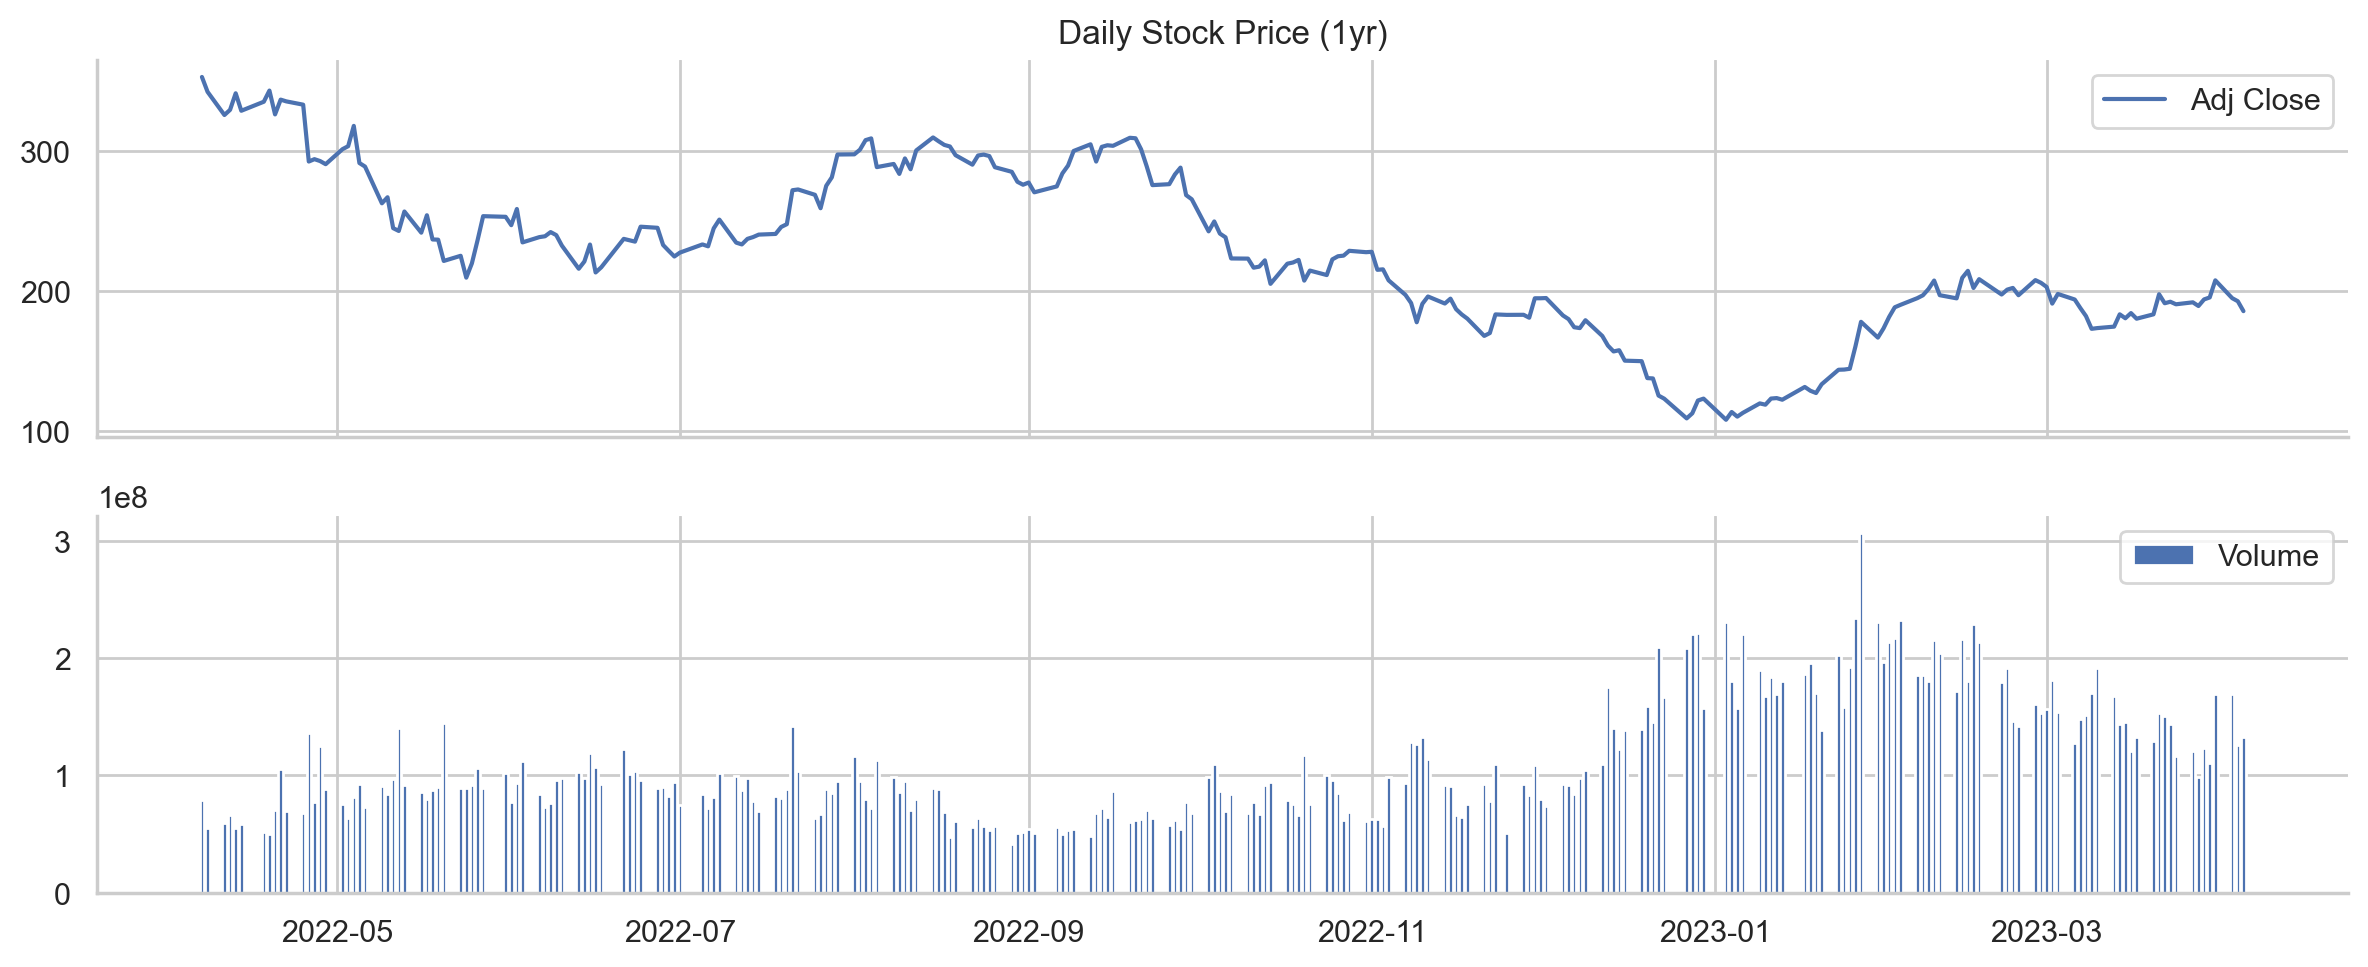

In [14]:
with sns.plotting_context('notebook'):
    fig, ax = plt.subplots(2, 1, sharex=True)

    (df[["Adj Close"]].plot(ax=ax[0], title="Daily Stock Price (1yr)"))
    ax[1].bar(df.index, df["Volume"].values, label="Volume")
    ax[1].legend()

    sns.despine()
    plt.tight_layout()

In [159]:
start = day_df['Adj Close'][0].round(2)
end = day_df['Adj Close'][-1].round(2)
diff = start - end
pct_diff = end / start

print(f'TSLA stock started the year at ${start} and ended at ${end}, a loss of ${diff} or {1-pct_diff.round(2)}.')

TSLA stock started the year at $352.42 and ended at $185.52, a loss of $166.9 or 0.47.


- It was a bad year for TSLA stock. If you had invested \\$100 a year ago, it would now be worth \\$53.

**Histograms of stock data**

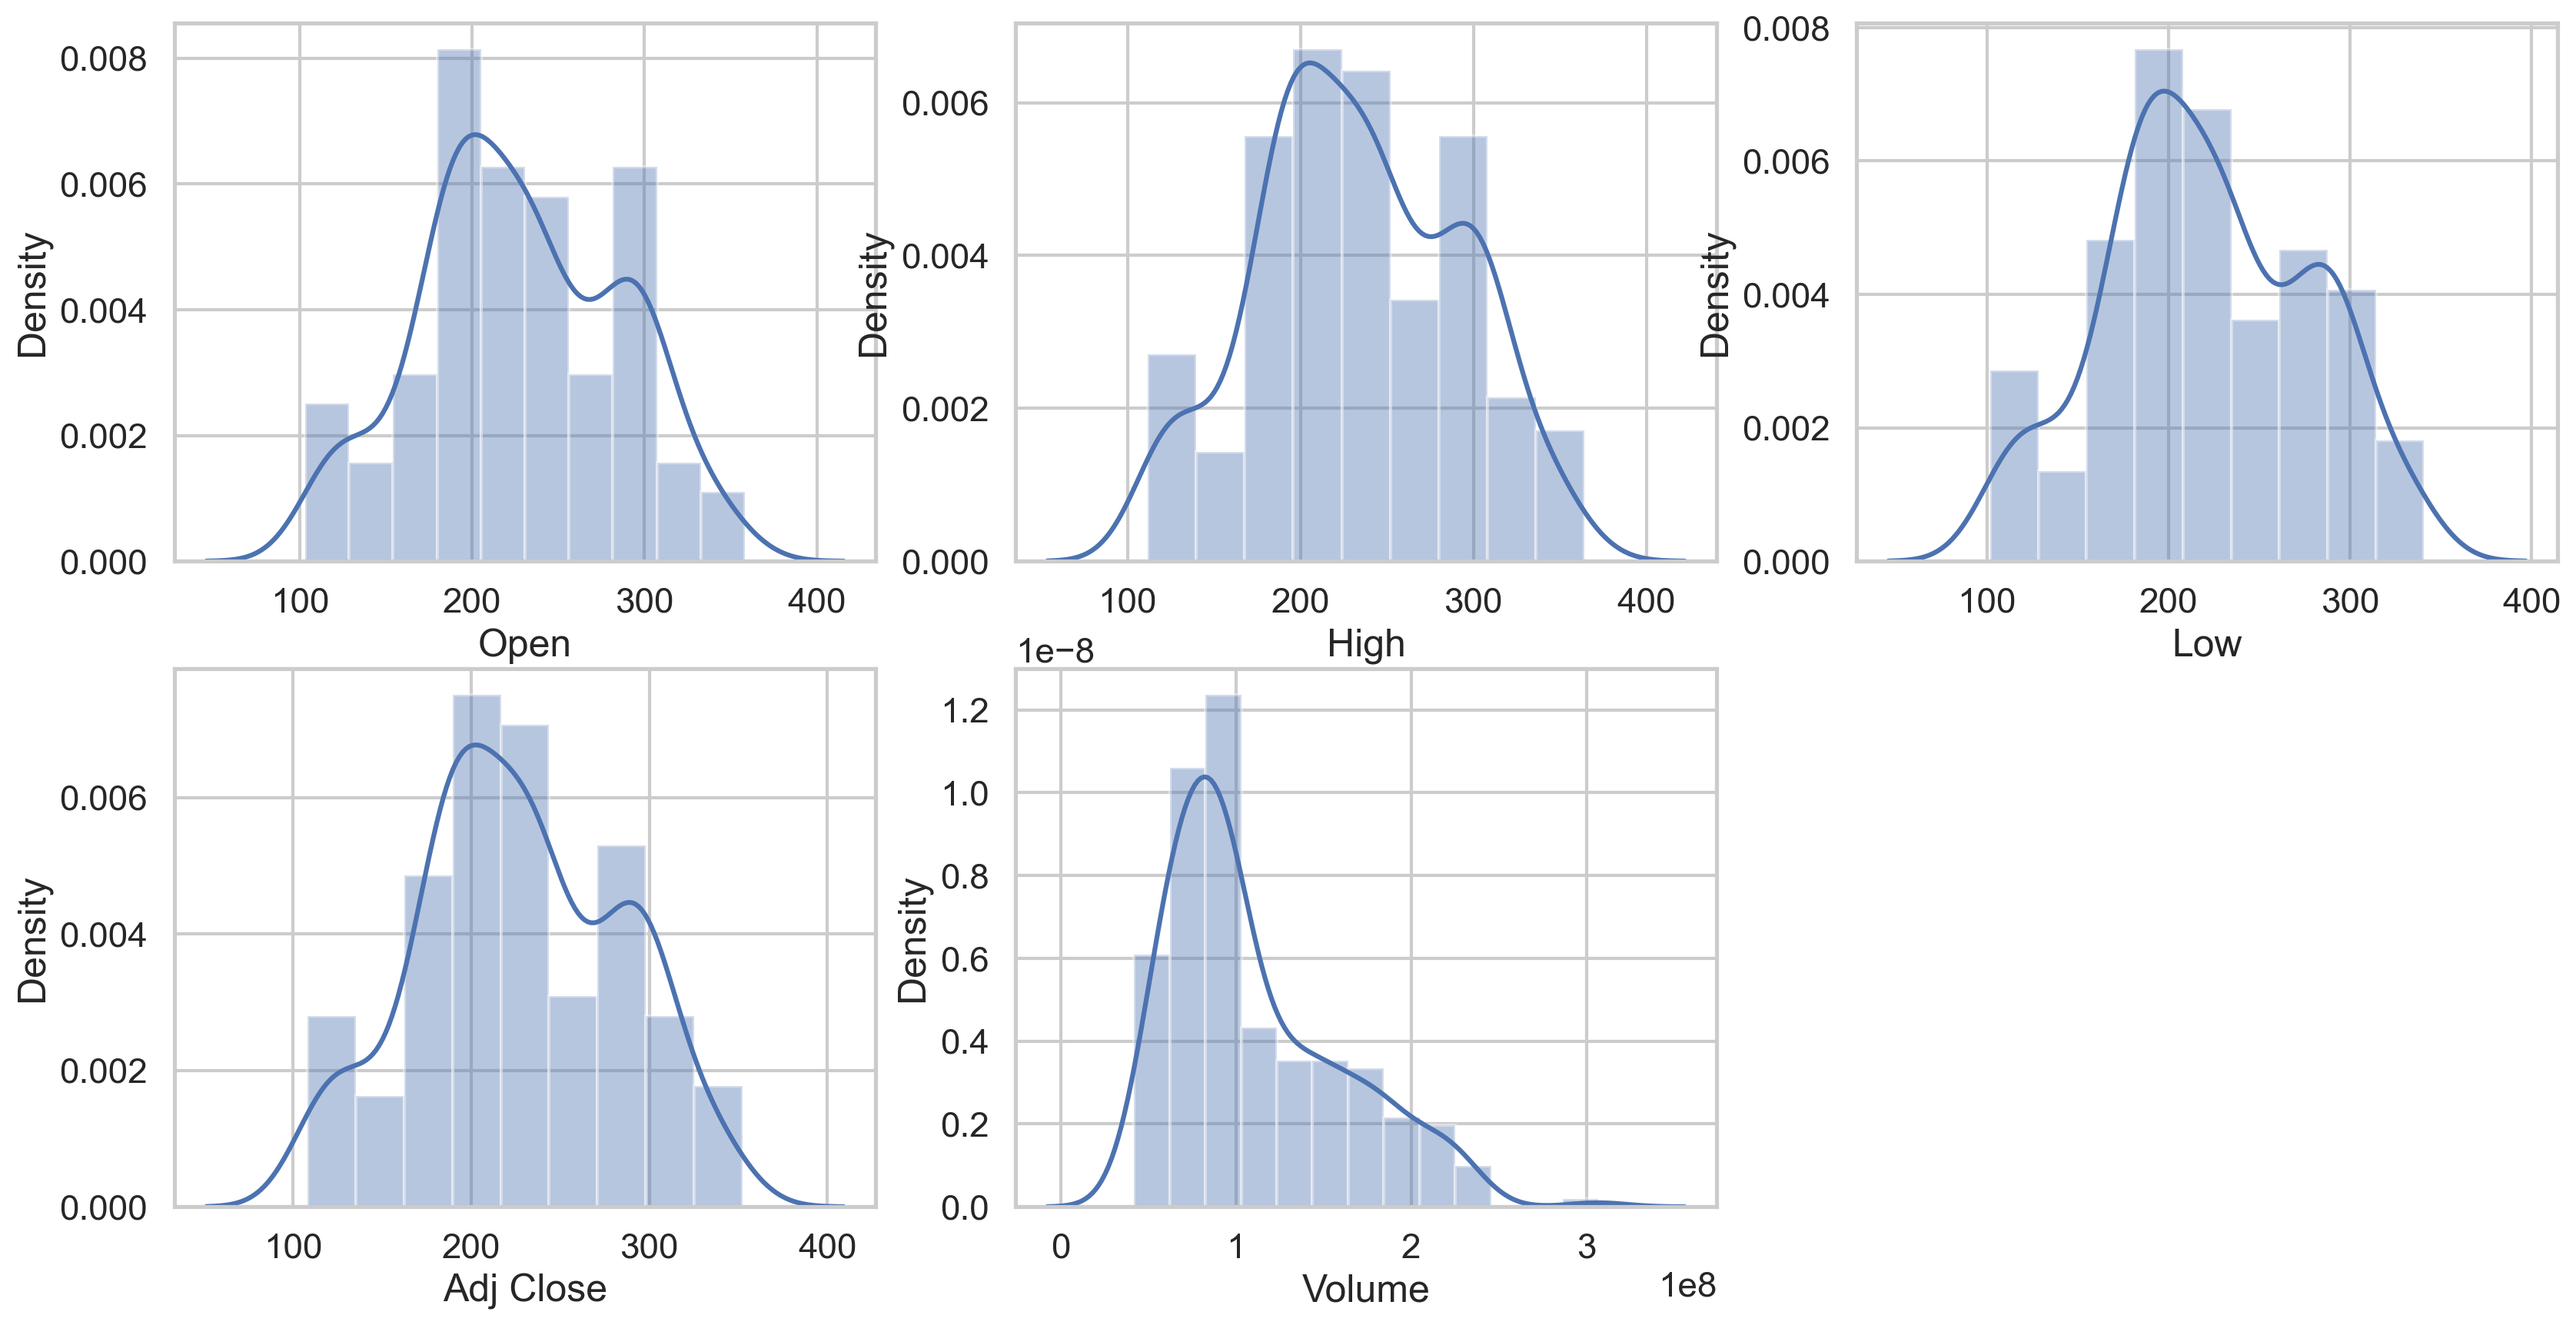

In [23]:
# histogram of features
cols = ['Open', 'High', 'Low', 'Adj Close', 'Volume']
 
plt.subplots(figsize=(20,10))
 
for i, col in enumerate(cols):
    plt.subplot(2,3,i+1)
    sns.distplot(df[col])

- In its raw form, the none of the features have a normal distribution. This will need to be addressed if a ML model used requires normal distribution

## Market indicator data comparison

In [27]:
nasdaqdatalink.ApiConfig.api_key = credentials.nasdaq_key

**Daily Treasury Long-Term Rates & TSLA stock price**

In [28]:
ltrt_df = (nasdaqdatalink.get(dataset="USTREASURY/LONGTERMRATES", start_date="2022-04-01", end_date="2023-03-31").rename(columns={"Value": "LT Treasury Rates"}))

[Text(0.5, 1.0, 'Long-term rate'), Text(0, 0.5, 'Long-term rate')]

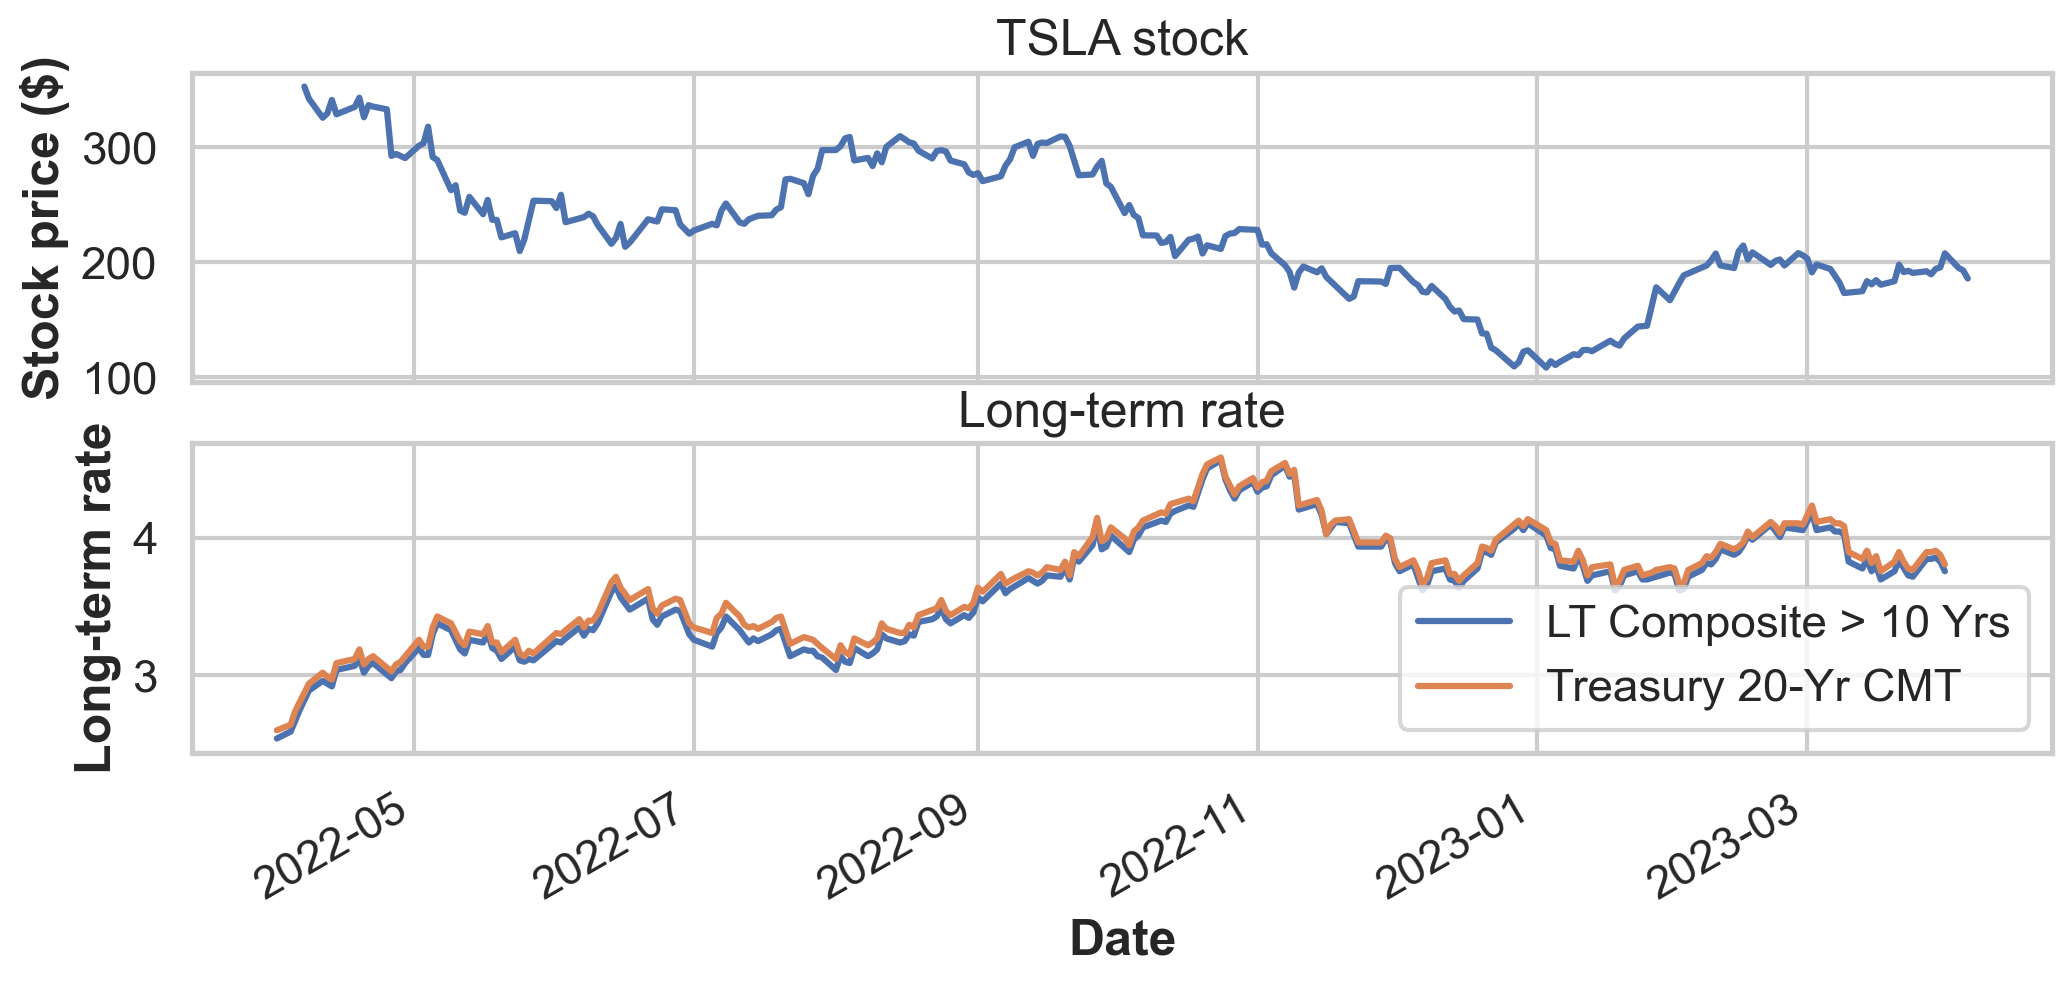

In [96]:
fig, ax = plt.subplots(2, 1, sharex=True)
day_df["Adj Close"].plot(ax=ax[0])
ax[0].set(title="TSLA stock", ylabel="Stock price ($)")
 
ltrt_df.plot(ax=ax[1])
ax[1].set(title='Long-term rate', ylabel="Long-term rate")

**Daily Treasury Par Real Yield Curve Rates**

In [30]:
ryc_df = (nasdaqdatalink.get(dataset="USTREASURY/REALYIELD", start_date="2022-04-01", end_date="2023-03-31"))

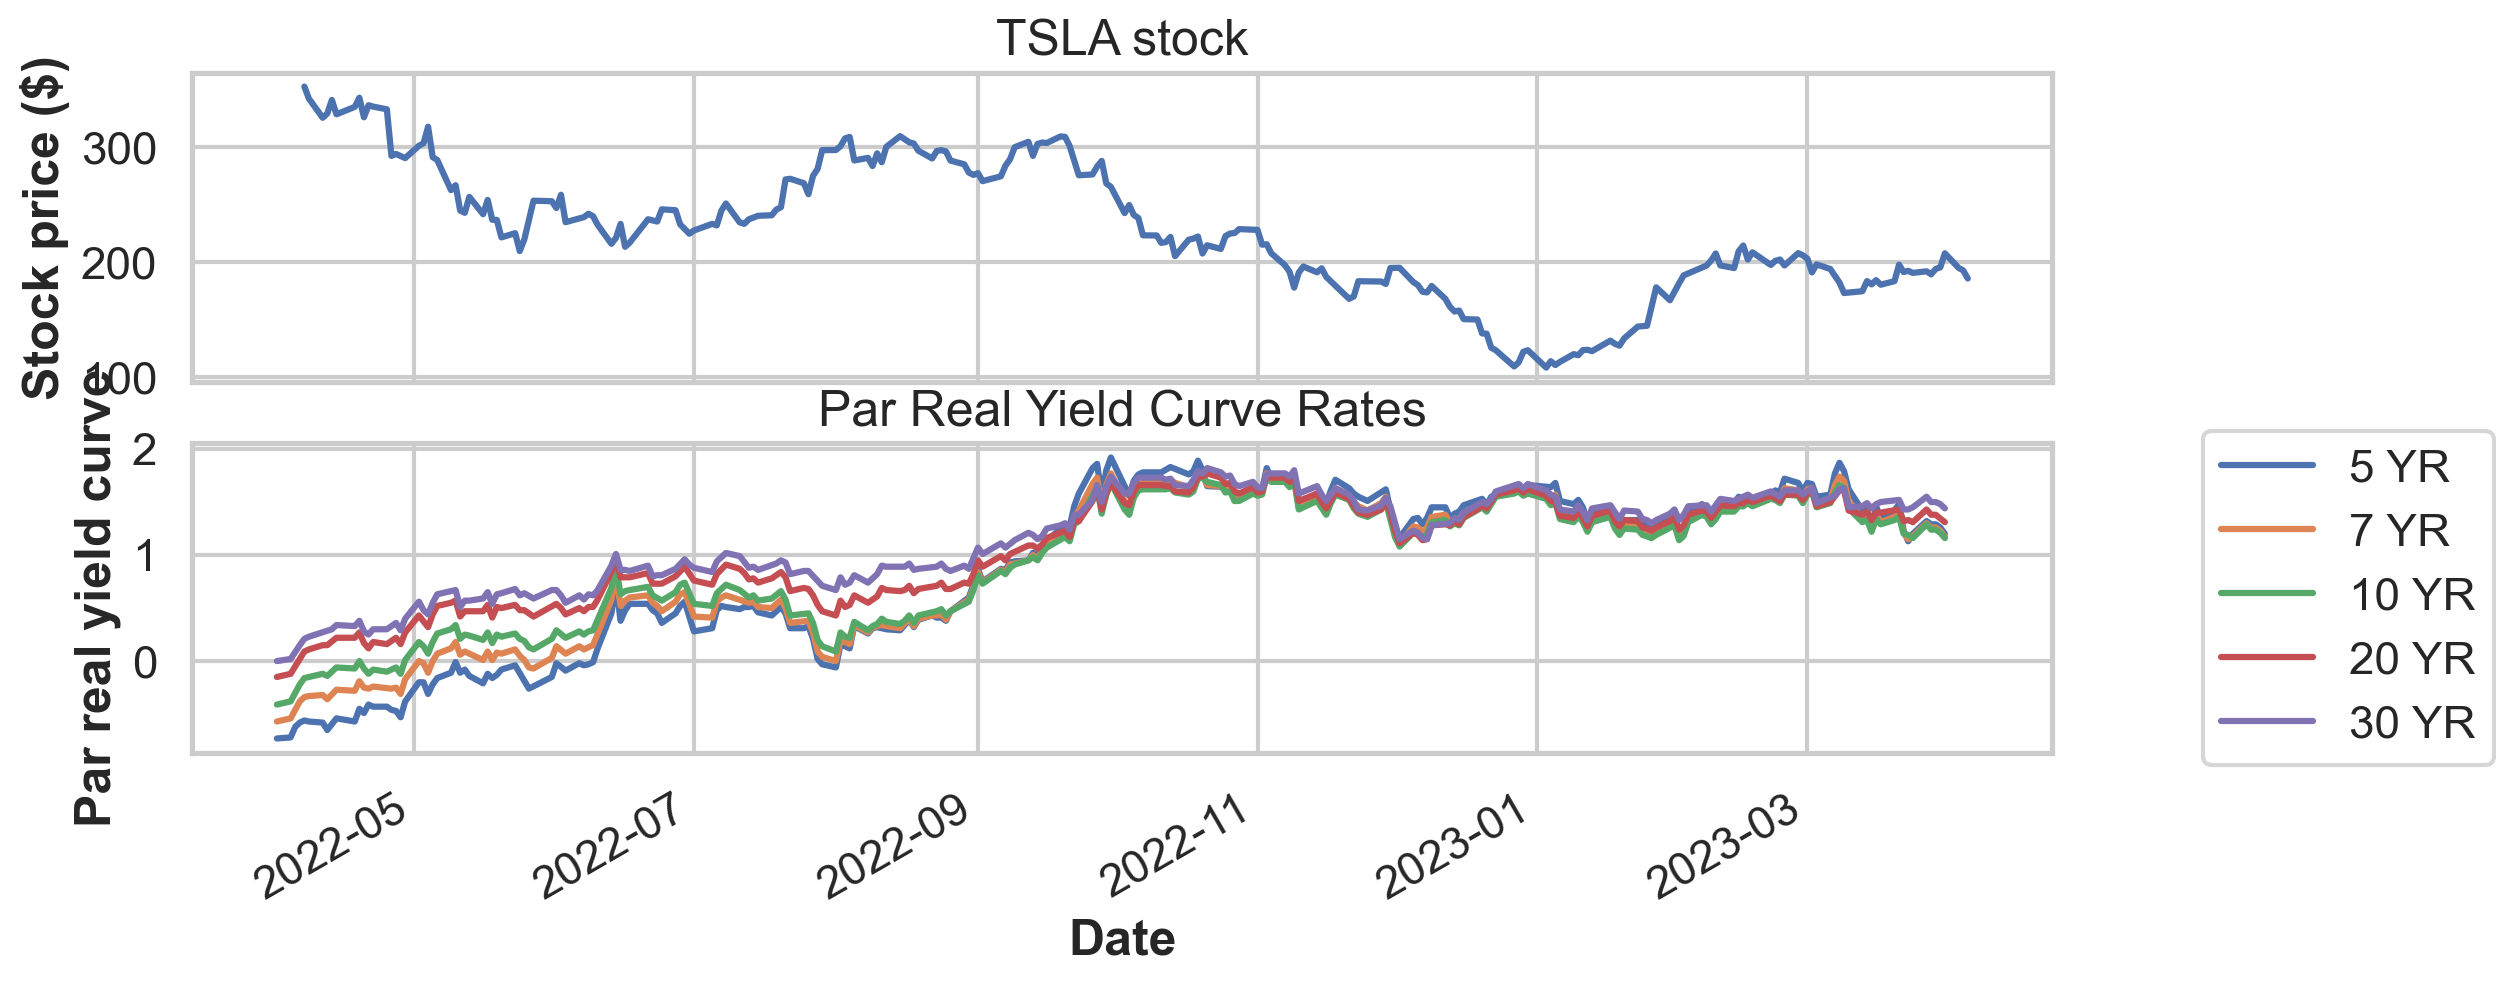

In [97]:
fig, ax = plt.subplots(2, 1, sharex=True)
day_df["Adj Close"].plot(ax=ax[0])
ax[0].set(title="TSLA stock", ylabel="Stock price ($)")
 
ryc_df.plot(ax=ax[1])
ax[1].set(title='Par Real Yield Curve Rates', ylabel="Par real yield curve")
ax[1].legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

**Daily Treasury Bill Rates**

In [32]:
tb_df = (nasdaqdatalink.get(dataset="USTREASURY/BILLRATES", start_date="2022-04-01", end_date="2023-03-31"))

In [65]:
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

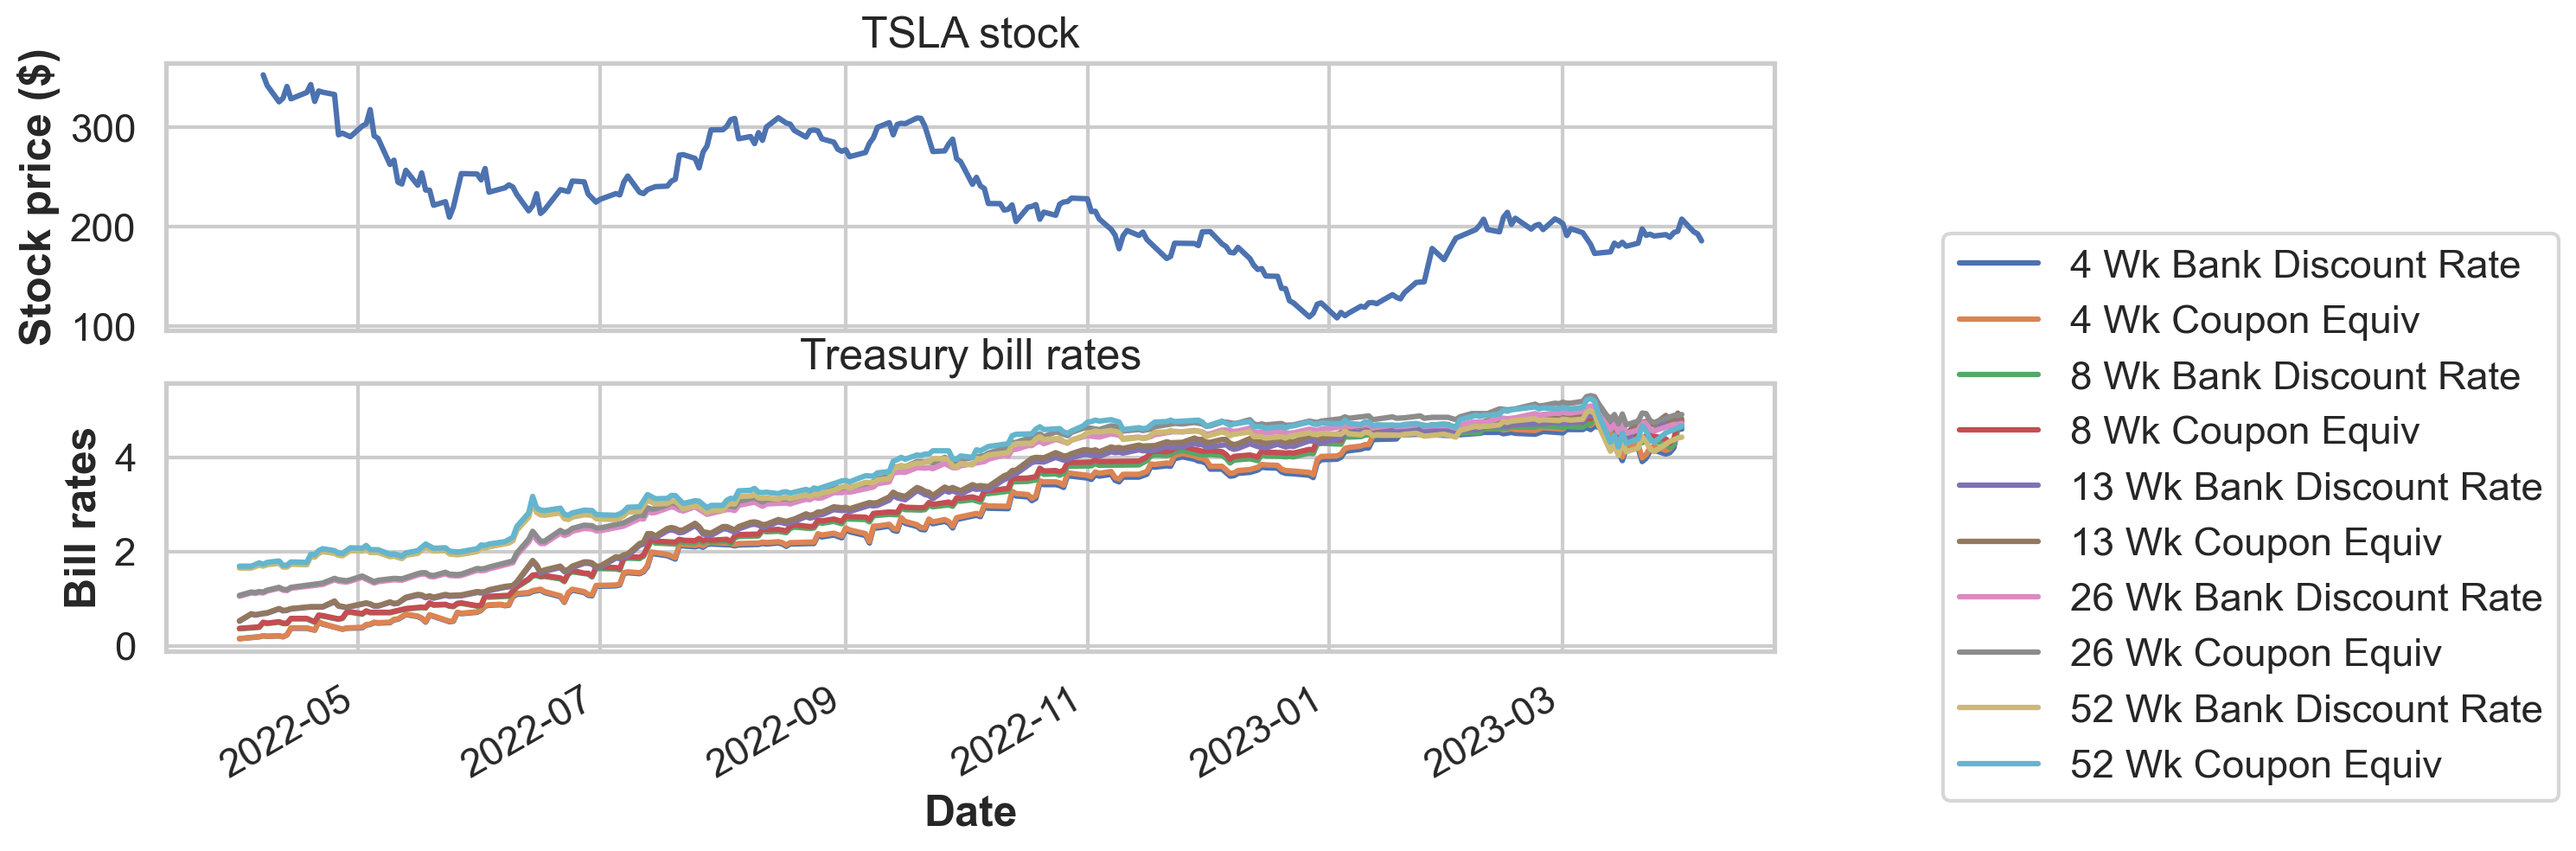

In [100]:
fig, ax = plt.subplots(2, 1, sharex=True)
day_df["Adj Close"].plot(ax=ax[0])
ax[0].set(title="TSLA stock", ylabel="Stock price ($)")
 
tb_df.plot(ax=ax[1])
ax[1].set(title='Treasury bill rates', ylabel="Bill rates")
ax[1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

**Daily Treasury Par Yield Curve Rates**

In [34]:
py_df = (nasdaqdatalink.get(dataset="USTREASURY/YIELD", start_date="2022-04-01", end_date="2023-03-31"))

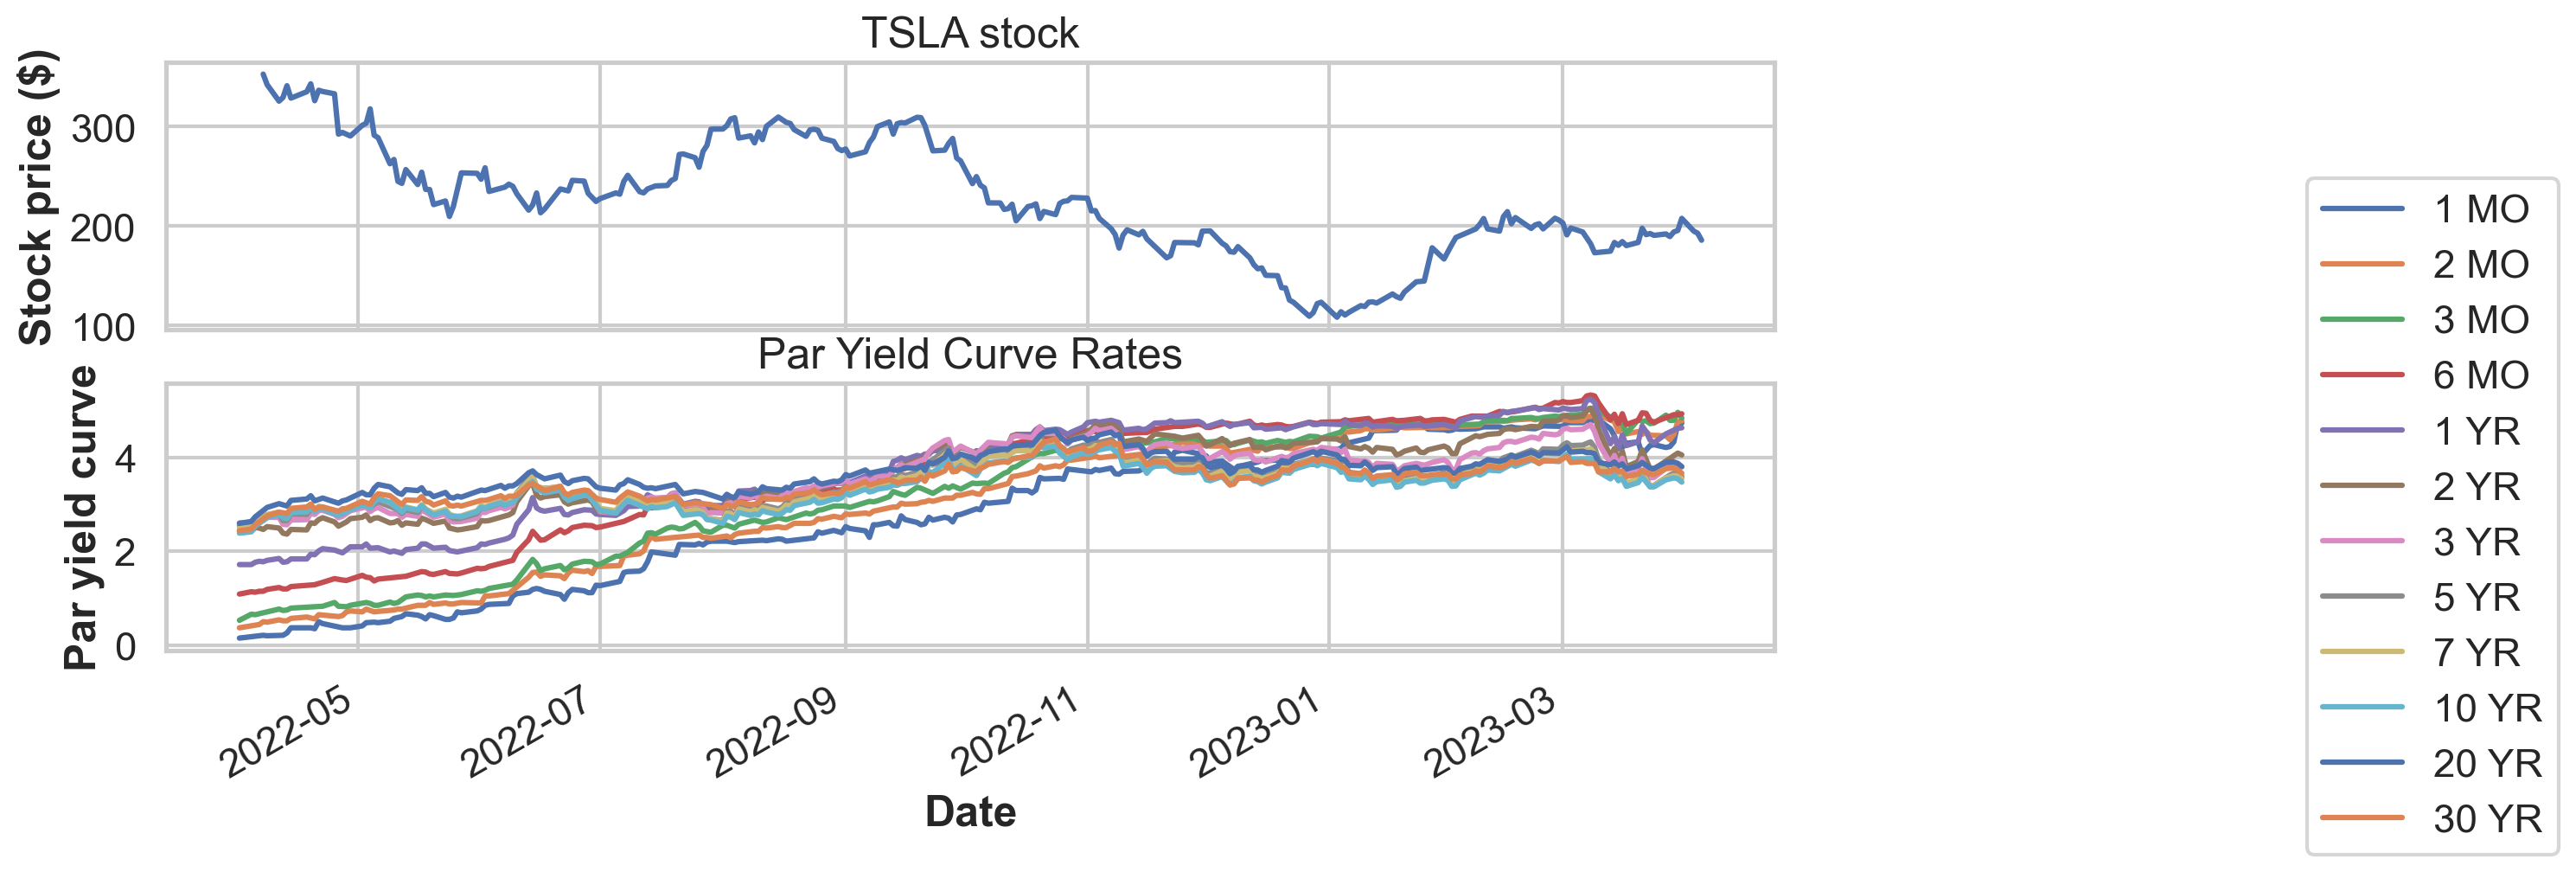

In [101]:
fig, ax = plt.subplots(2, 1, sharex=True)
day_df["Adj Close"].plot(ax=ax[0])
ax[0].set(title="TSLA stock", ylabel="Stock price ($)")
 
py_df.plot(ax=ax[1])
ax[1].set(title='Par Yield Curve Rates', ylabel="Par yield curve")
ax[1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

### Financial industry regulatory authority (FINRA) data
**Short interest**
- Daily short volume

In [36]:
si_df = (nasdaqdatalink.get(dataset="FINRA/FNYX_TSLA", start_date="2022-04-01", end_date="2023-04-04"))

In [37]:
# removing 'exempt volumne'
si_df = si_df[['ShortVolume', 'TotalVolume']]

[Text(0.5, 1.0, 'TSLA short interest'), Text(0, 0.5, 'Volume')]

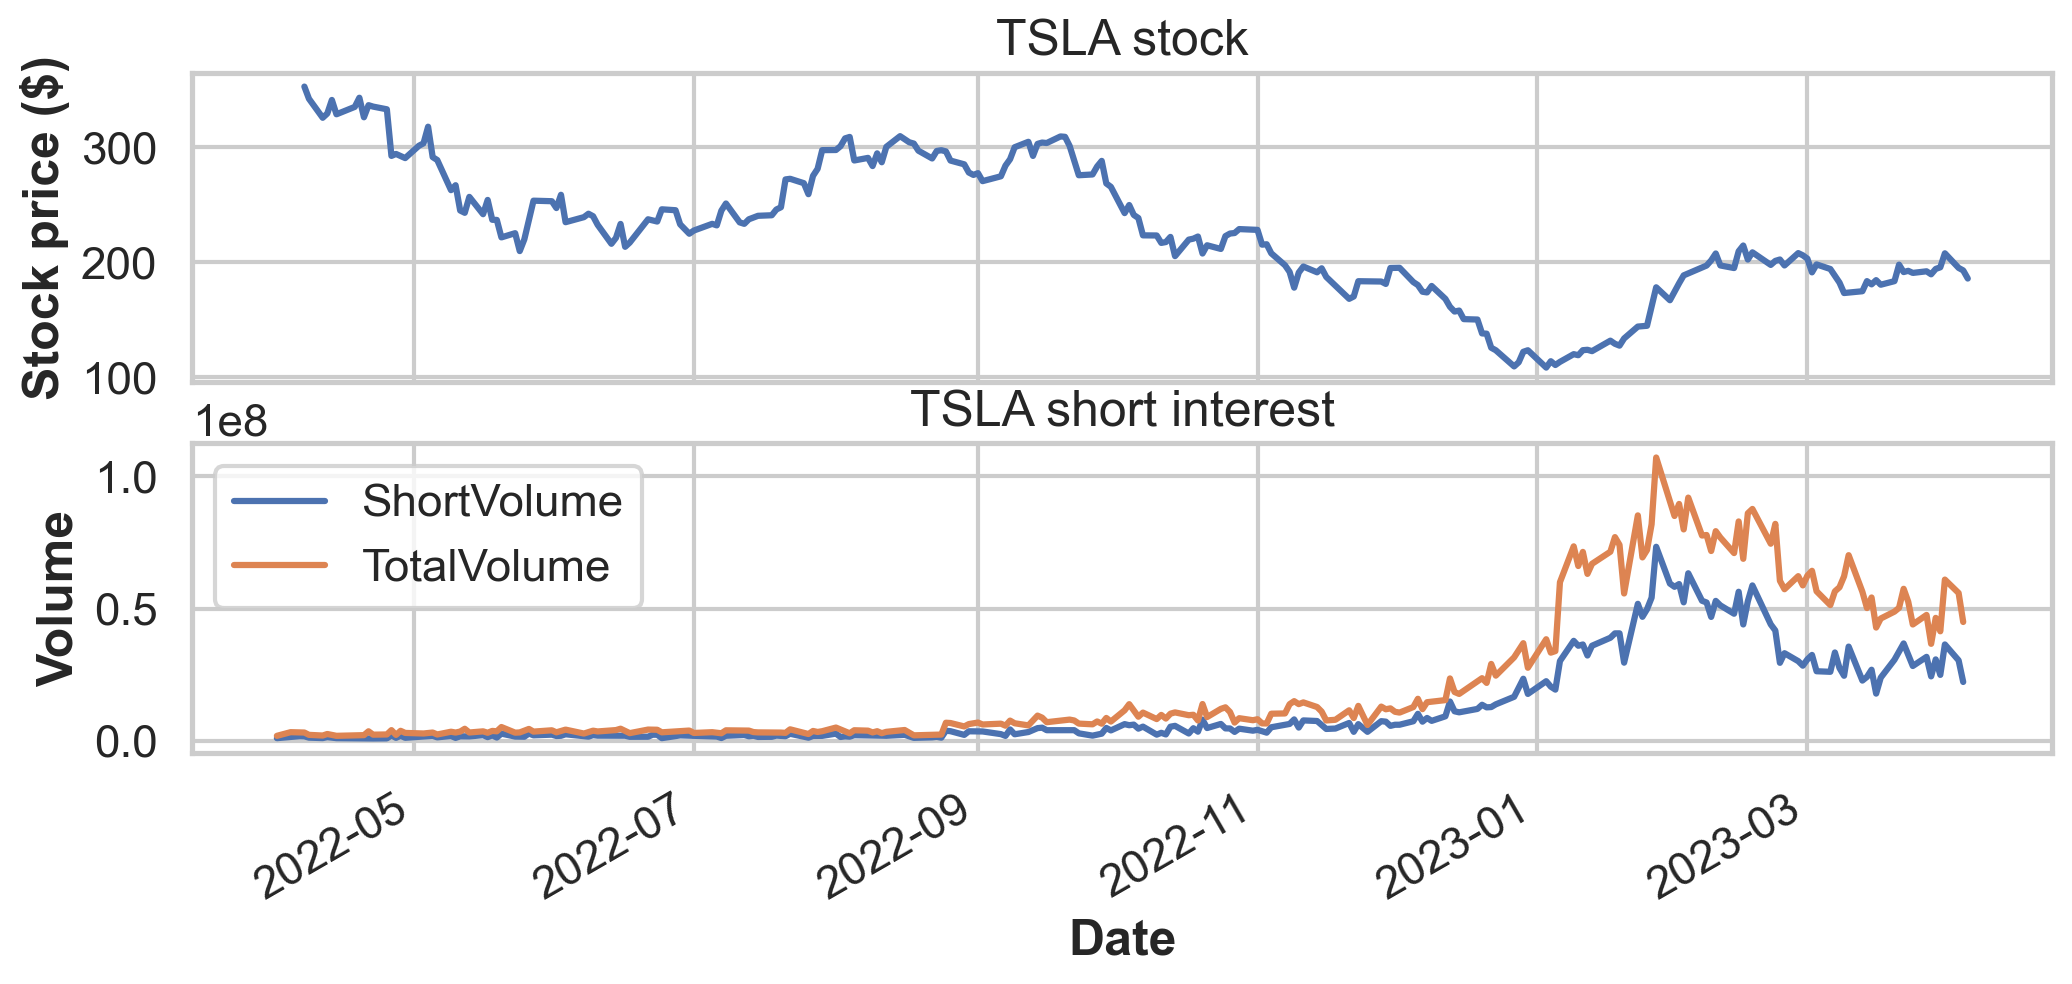

In [102]:
fig, ax = plt.subplots(2, 1, sharex=True)
day_df["Adj Close"].plot(ax=ax[0])
ax[0].set(title="TSLA stock", ylabel="Stock price ($)")
 
si_df.plot(ax=ax[1])
ax[1].set(title='TSLA short interest', ylabel="Volume")

- I didn't find any worthy uses with the US Treasury data so that will not be utilized moving forward
- However, the FINRA short interest may be of use

### Calculated indicators

**Simple moving averages**
- Pandas has a built-in `rolling()` function that can be used to calculate simple rolling averages (SMAs) and there are also  libraries with SMA calculators, such as cufflinks
- To obtain these calculations, I borrowed code from this Medium article to save time
> link: https://guese-justin.medium.com/enhancing-stock-data-for-your-python-algorithmic-trading-model-b40c668e4087

In [39]:
sma_df = day_df[['Adj Close']]

In [40]:
# specify rolling averages
averages = [5, 15, 30]

for average in averages:
    sma_df['SMA_%d'%average] = sma_df["Adj Close"].rolling(window=average).mean()
    
# dropping nulls as I am most interested in recent data
sma_df.dropna(inplace=True)

In [41]:
sma_df.head()

Adj Close       SMA_5      SMA_15      SMA_30
Date                                                      
2022-05-19  236.473328  244.986664  268.854443  297.870890
2022-05-20  221.300003  237.940665  264.257555  293.500223
2022-05-23  224.966660  234.642664  259.189998  289.604779
2022-05-24  209.386673  225.745999  252.943554  285.740668
2022-05-25  219.600006  222.345334  246.414220  282.094557

<AxesSubplot:title={'center':'TSLA Adjusted Close vs Simple Moving Averages'}, xlabel='Date'>

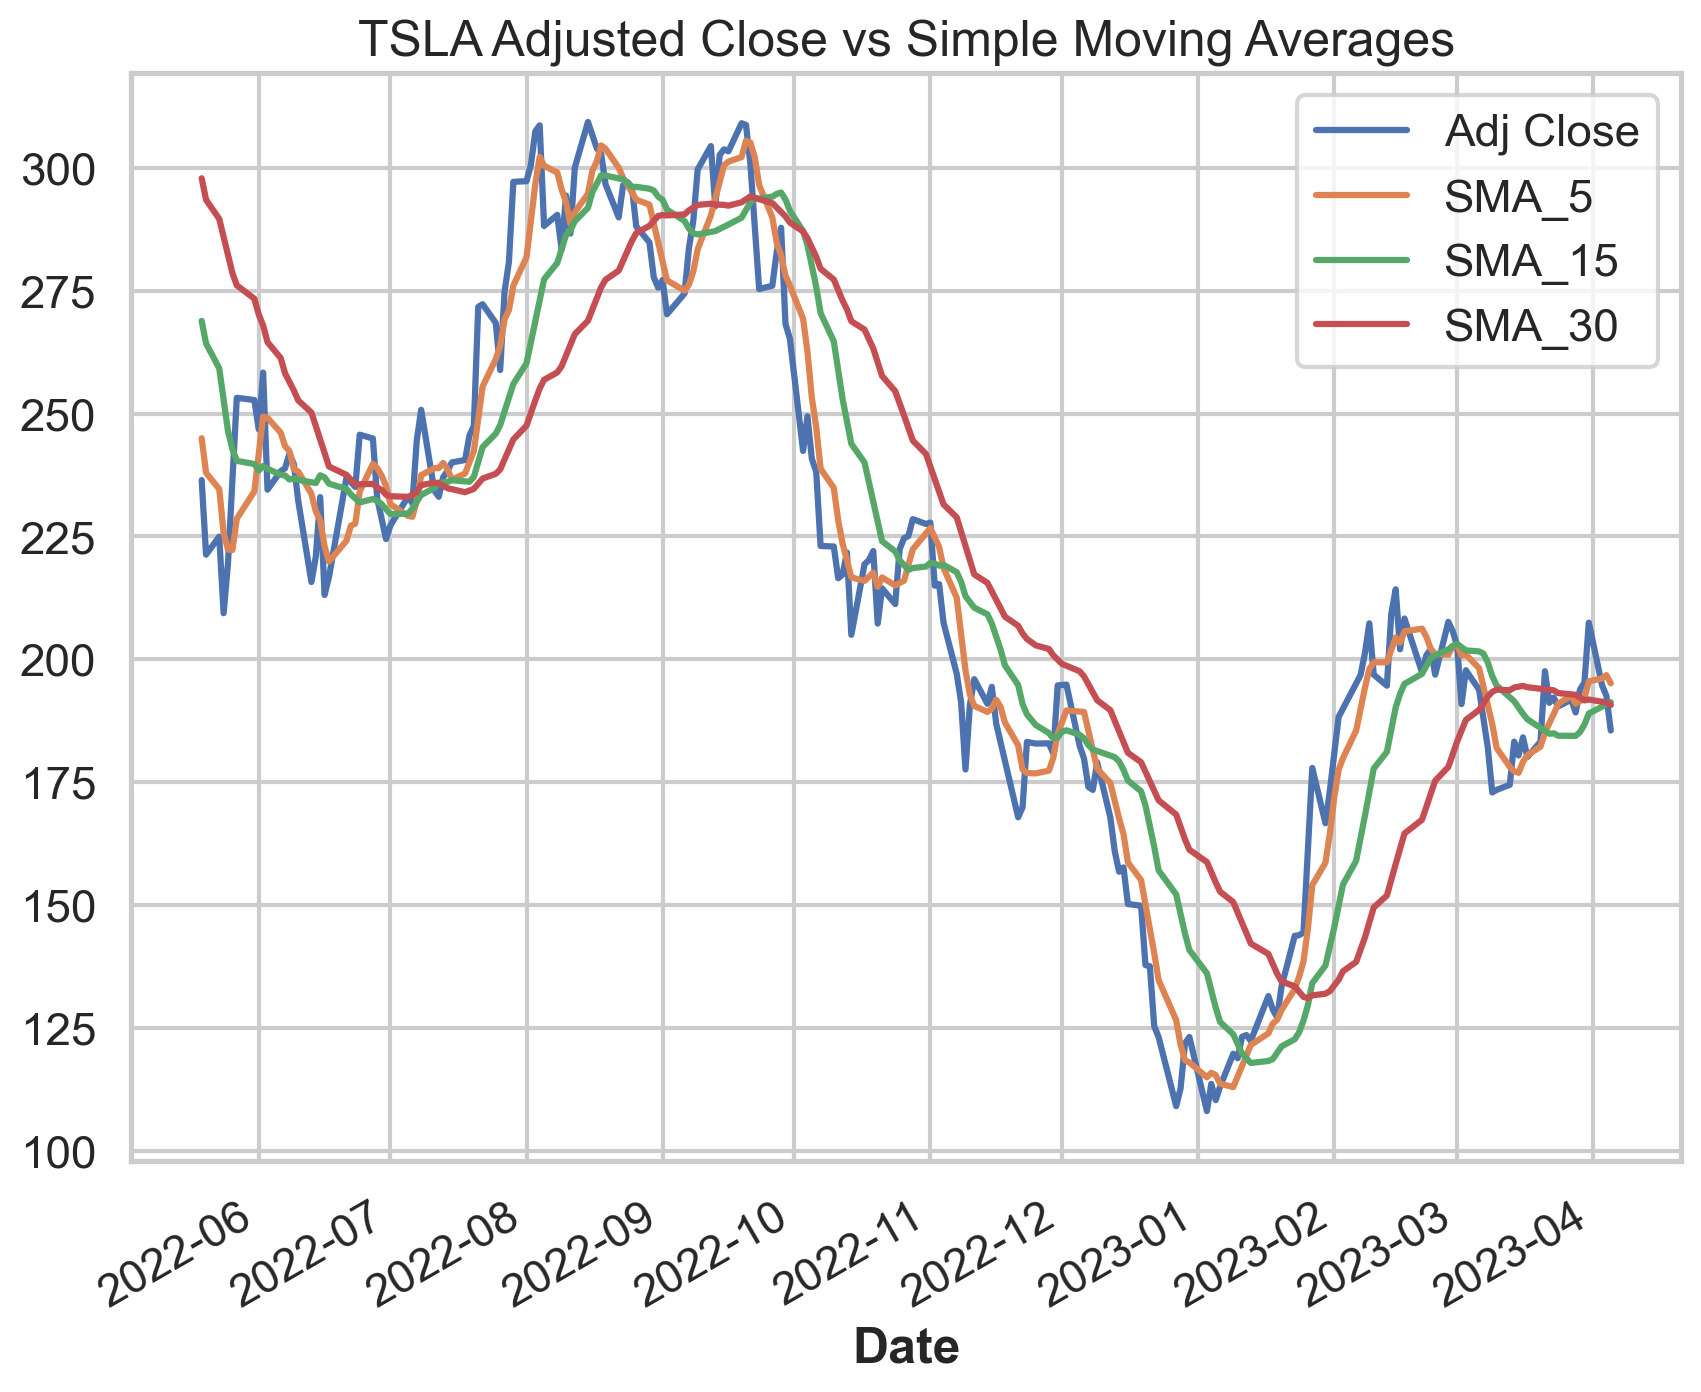

In [104]:
plt.rcParams["figure.figsize"] = (10,8)
sma_df.plot(title="TSLA Adjusted Close vs Simple Moving Averages")

- Before working with SMAs I was unsure of the meaning behind SMA 'crosses' but it wasn't until this project that I understand the reasoning
- Even if SMAs aren't included in the ML modeling, the cross indicators could still be utilized

**Volatility**
- Trading volatility can be determined by taking the rolling average of the standard deviation of the log returns
- In this plot I'll look at 15 & 25-day averages

In [123]:
df = day_df.copy()
df = df.loc[:, ["Adj Close", "% change (ln)", "Volume"]]
df["moving_std_25"] = df[["% change (ln)"]].rolling(window=25).std()
df["moving_std_15"] = df[["% change (ln)"]].rolling(window=15).std()

df.tail()

Adj Close  % change (ln)    Volume  moving_std_25  moving_std_15
Date                                                                         
2022-04-07  352.420013       0.010937  79447200            NaN            NaN
2022-04-08  341.829987      -0.030510  55013700            NaN            NaN
2022-04-11  325.309998      -0.049535  59357100            NaN            NaN
2022-04-12  328.983337       0.011229  65976000            NaN            NaN
2022-04-13  340.790009       0.035259  55121100            NaN            NaN

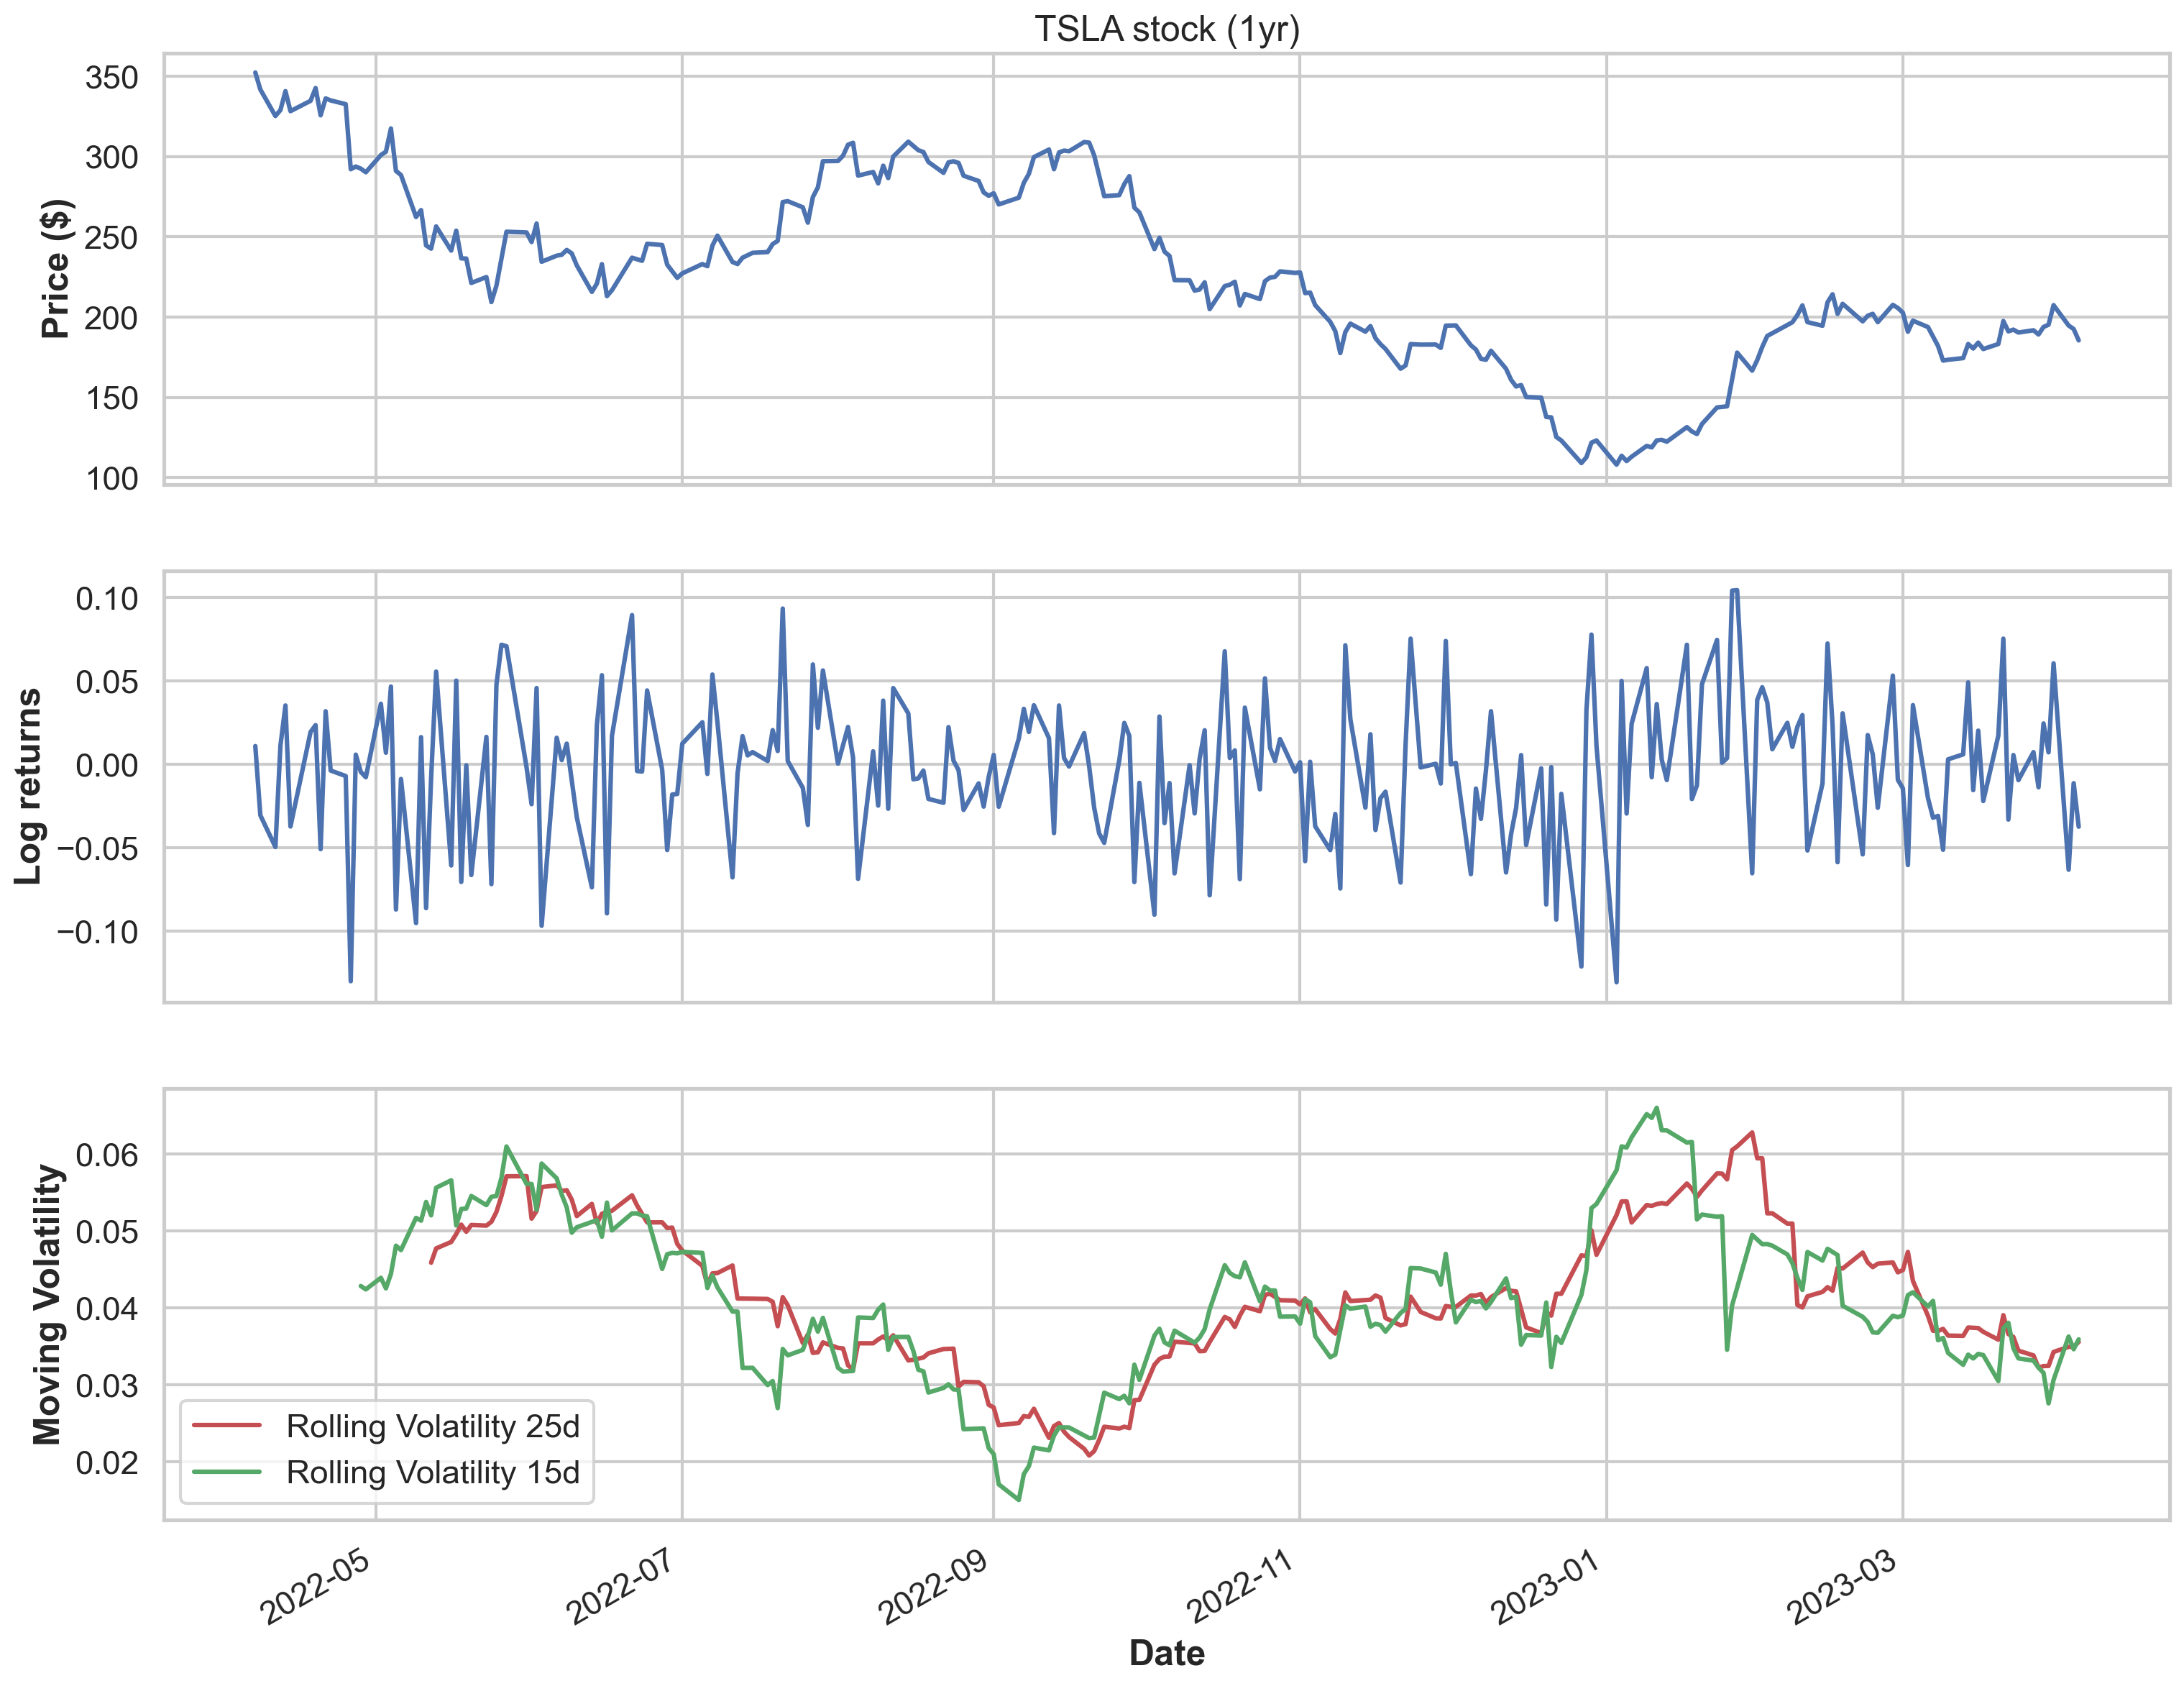

In [126]:
fig, ax = plt.subplots(3, 1, figsize=(18, 15), sharex=True)
df["Adj Close"].plot(ax=ax[0])
ax[0].set(title="TSLA stock (1yr)", ylabel="Price ($)")
df["% change (ln)"].plot(ax=ax[1])
ax[1].set(ylabel="Log returns")
df["moving_std_25"].plot(ax=ax[2], color="r", label="Rolling Volatility 25d")
df["moving_std_15"].plot(ax=ax[2], color="g", label="Rolling Volatility 15d")
ax[2].set(ylabel="Moving Volatility", xlabel="Date")
ax[2].legend()

- In analyzing the rolling volatility, I'm looking for indications of the 'leverage effect', which would show a negative correlation between the stock's price level and its rolling volatility (i.e. stock price falls - rolling volatility increases, and vice versa
- If you look closely, there are some indications of this
- Minor movements in the 25d average correspond with major movements in the 15d average, and small changes in price 

**Relative strength index**
- The relative strength index (RSI) measures the strength of a stock's price action. It can be used to identify overbought or oversold conditions
- The Technical Analysis Library (TA-Lib) will be used to calculate the RSI

In [142]:
import talib

In [143]:
rsi_df = day_df[['Adj Close']]

In [144]:
rsi_df['rsi'] = talib.RSI(rsi_df['Adj Close'])

# only interested in recent data
rsi_df.dropna(inplace=True)
rsi_df.head()

Adj Close        rsi
Date                             
2022-04-28  292.503326  29.208593
2022-04-29  290.253326  28.725533
2022-05-02  300.980011  34.303792
2022-05-03  303.083344  35.371896
2022-05-04  317.540009  42.313959

In [145]:
# looking at only 1 year of data
one_yr = pd.Timestamp('today') - pd.DateOffset(years=1)
rsi_df = rsi_df.loc[one_yr:]

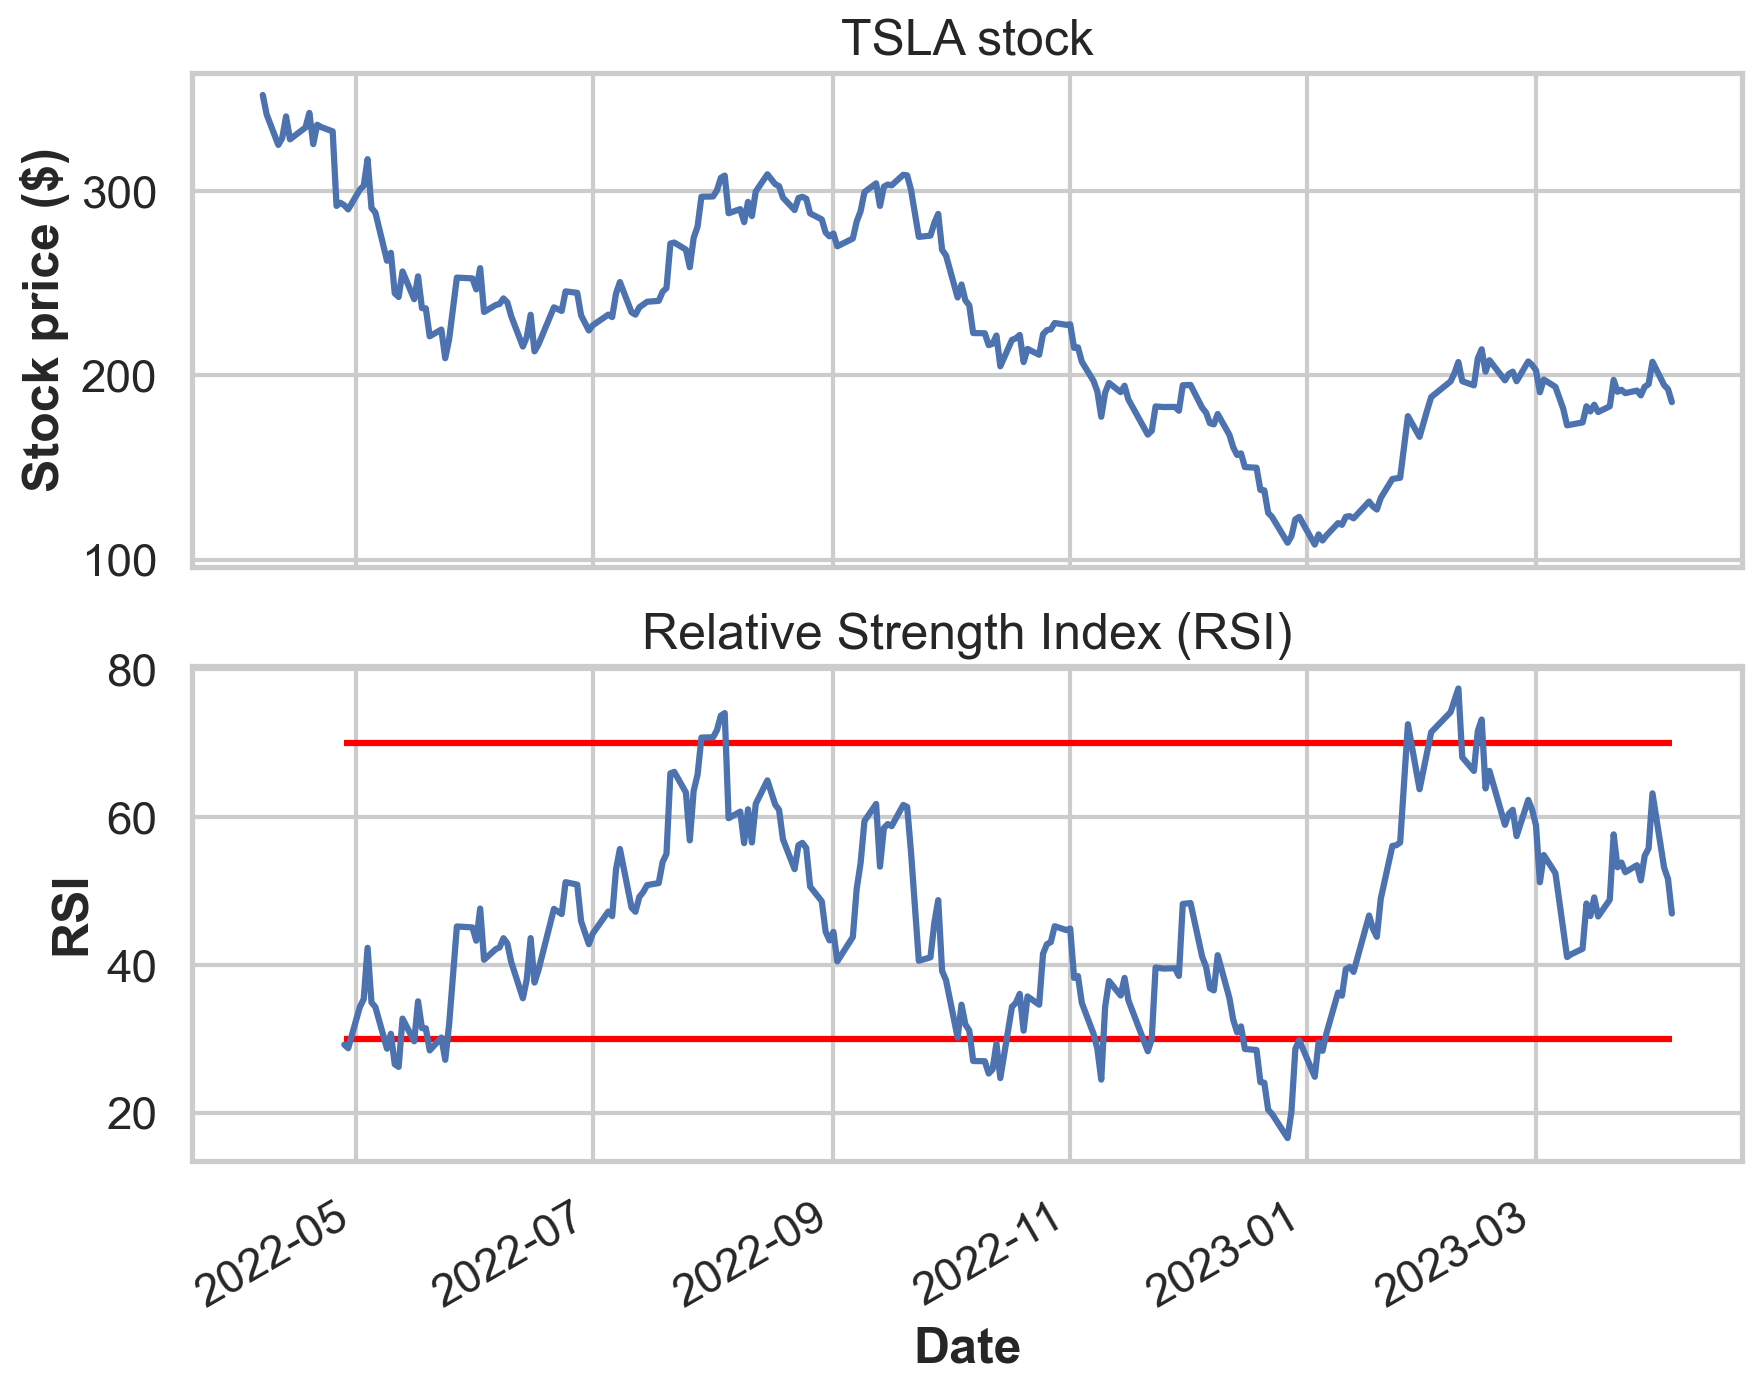

In [146]:
fig, ax = plt.subplots(2, 1, sharex=True)
day_df["Adj Close"].plot(ax=ax[0])
ax[0].set(title="TSLA stock", ylabel="Stock price ($)")
 
rsi_df.rsi.plot(ax=ax[1])
ax[1].set(title="Relative Strength Index (RSI)", ylabel="RSI")
ax[1].hlines(y=30, xmin=rsi_df.index.min(), xmax=rsi_df.index.max(), color="red")
ax[1].hlines(y=70, xmin=rsi_df.index.min(), xmax=rsi_df.index.max(), color="red")

- Correlation is present with the stock rising when the stock is oversold (under red line) and vice versa

**Bollinger Bands**
- This indicator uses a moving average and a certain number of standard deviations to create an upper and lower band around the stock price. When the stock price reaches the upper band, it could be an indication that the stock is overbought, and thus a potential sell signal. When the price reaches the lower band, it could be an indication that the stock is oversold, and thus a potential buy signal.

In [69]:
df = day_df.copy()

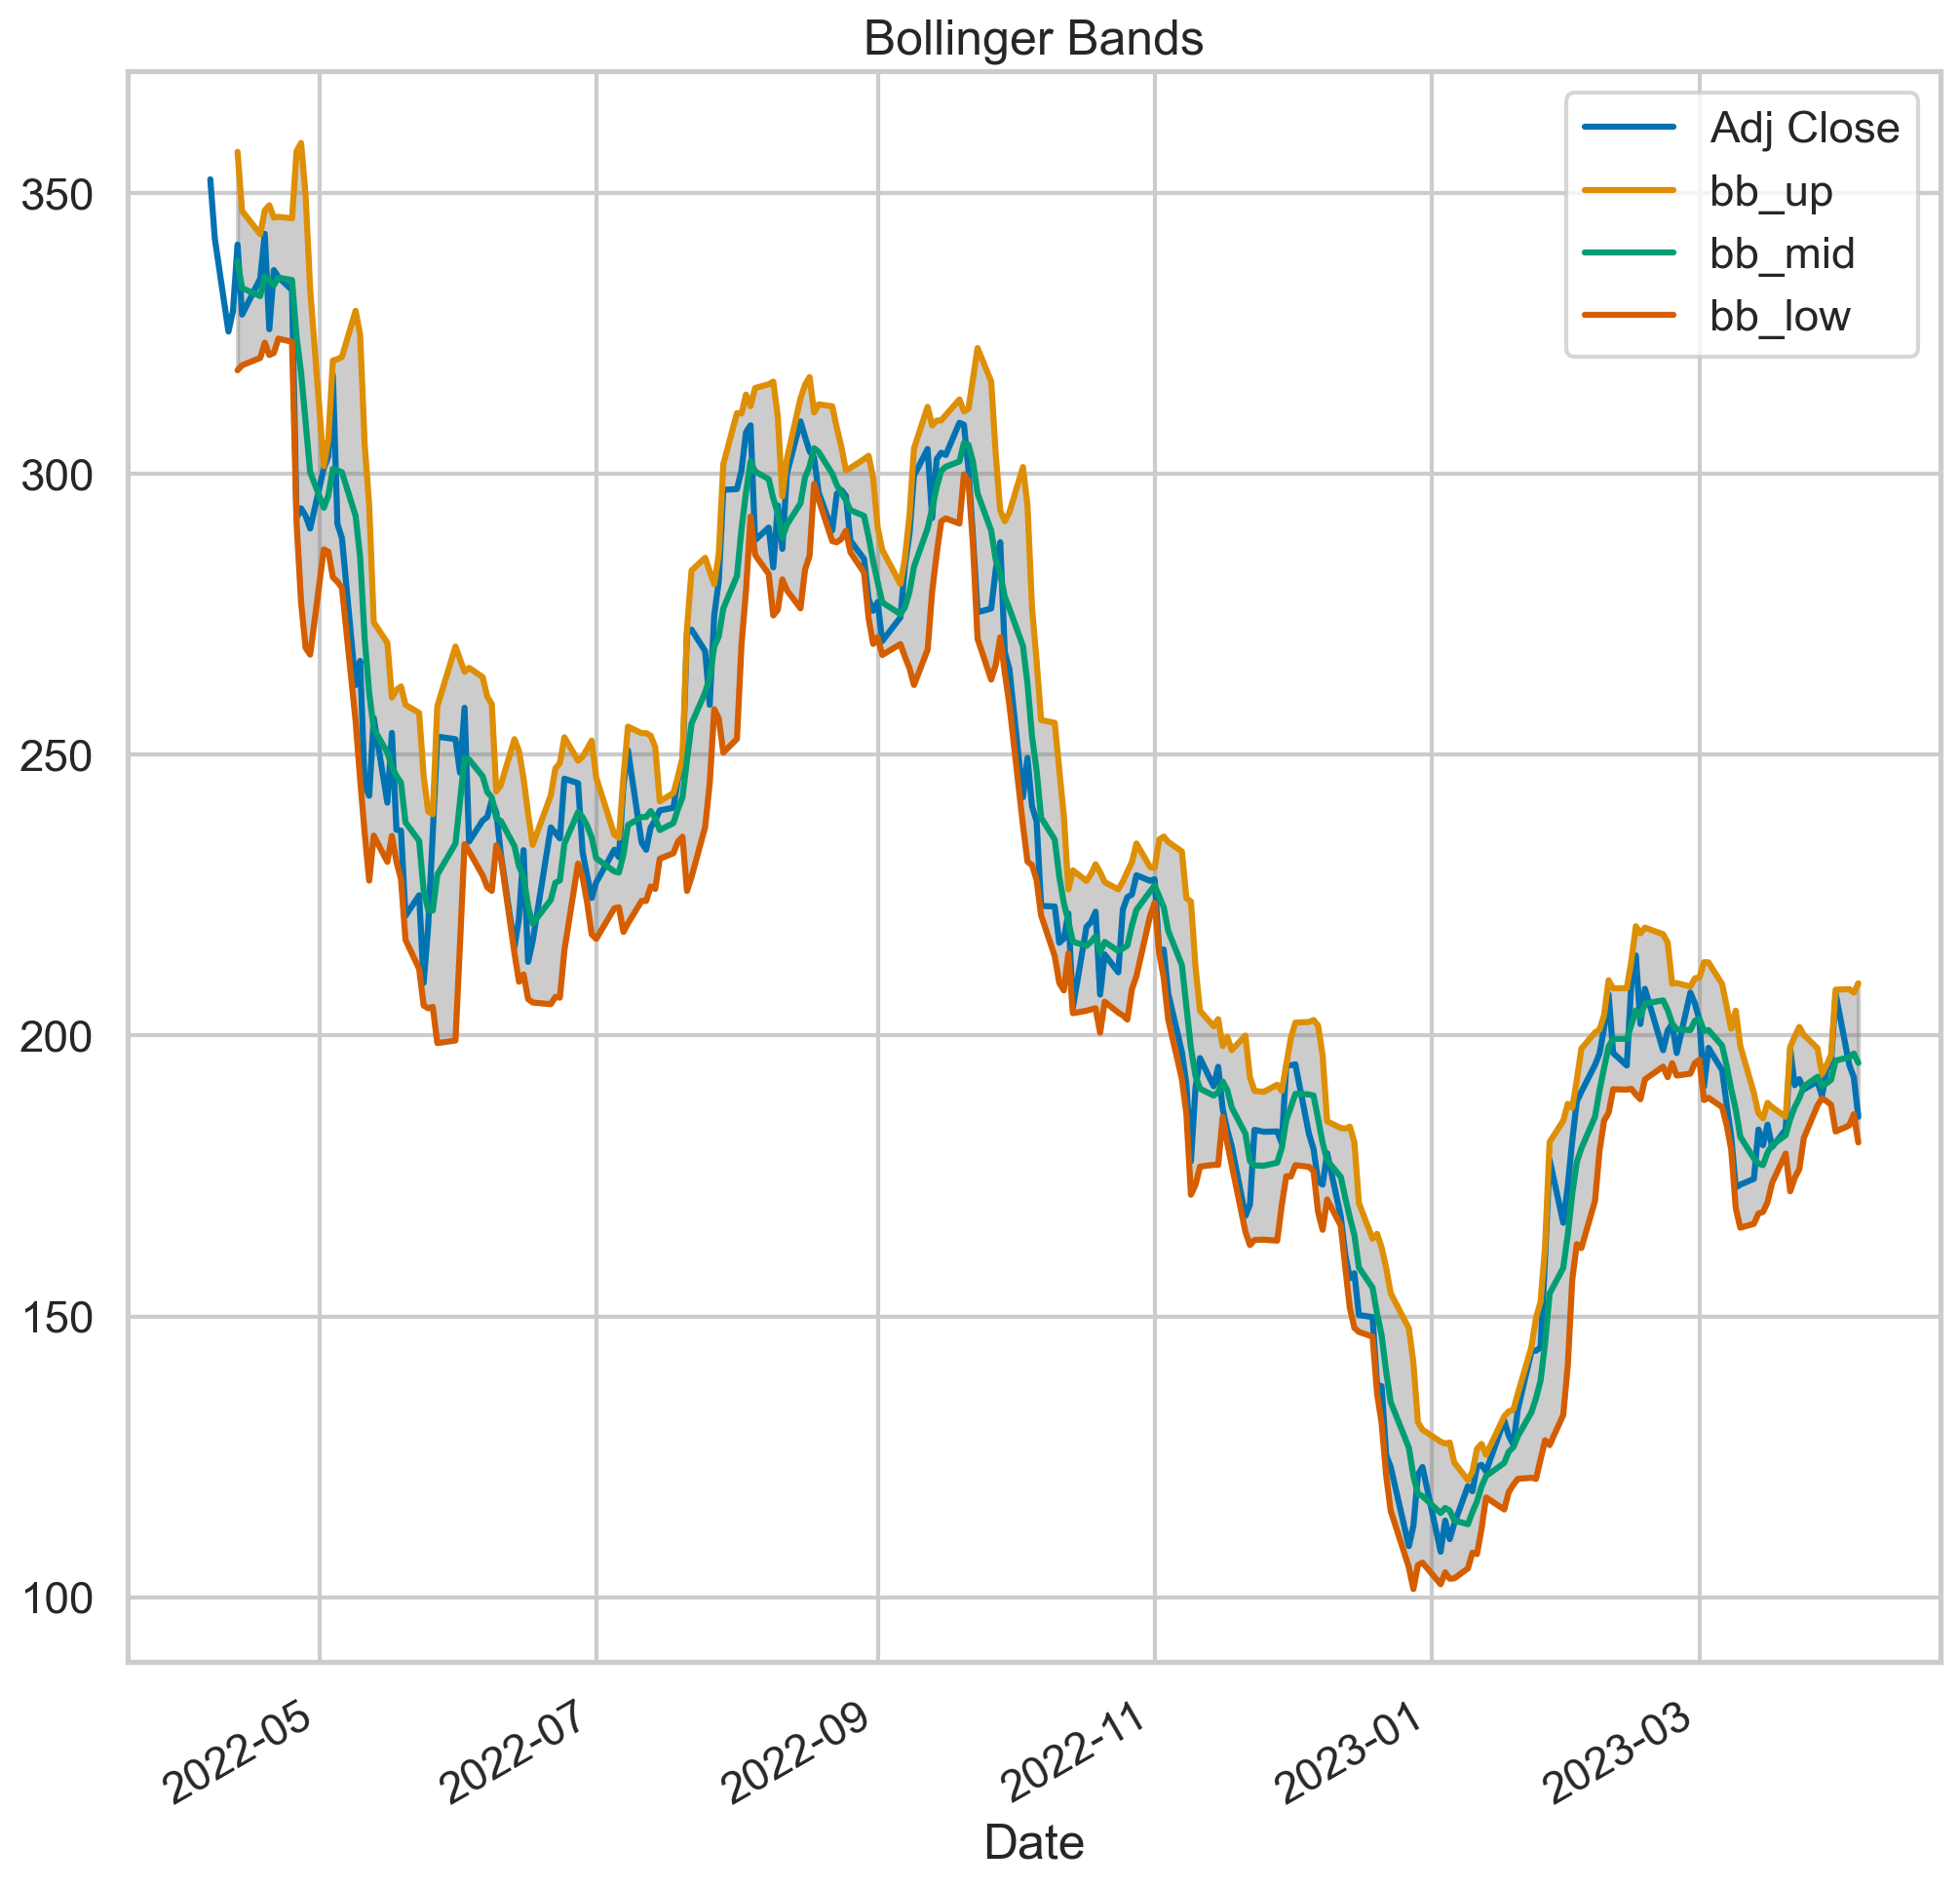

In [53]:
df["bb_up"], df["bb_mid"], df["bb_low"] = talib.BBANDS(df["Adj Close"])
fig, ax = plt.subplots()
(
 df.loc[:, ["Adj Close", "bb_up", "bb_mid", "bb_low"]]
 .plot(ax=ax, title="Bollinger Bands")
)
ax.fill_between(df.index, df["bb_low"], df["bb_up"], 
 color="gray", 
 alpha=.4)

- Correlation is present with the stock rising when the TSLA price nears the lower band and vice versa, however caution is needed as this indicator is not always reliable (see end of 2022)

**Moving average convergence divergence (MACD)**
-  The MACD indicator is calculated using the difference between two moving averages, and a third moving average as a signal line. When the MACD line crosses above the signal line, this indicates a buy signal, and when the MACD line crosses below the signal line, it indicates a sell signal. A MACD histogram is also used to show the strength of the trend.

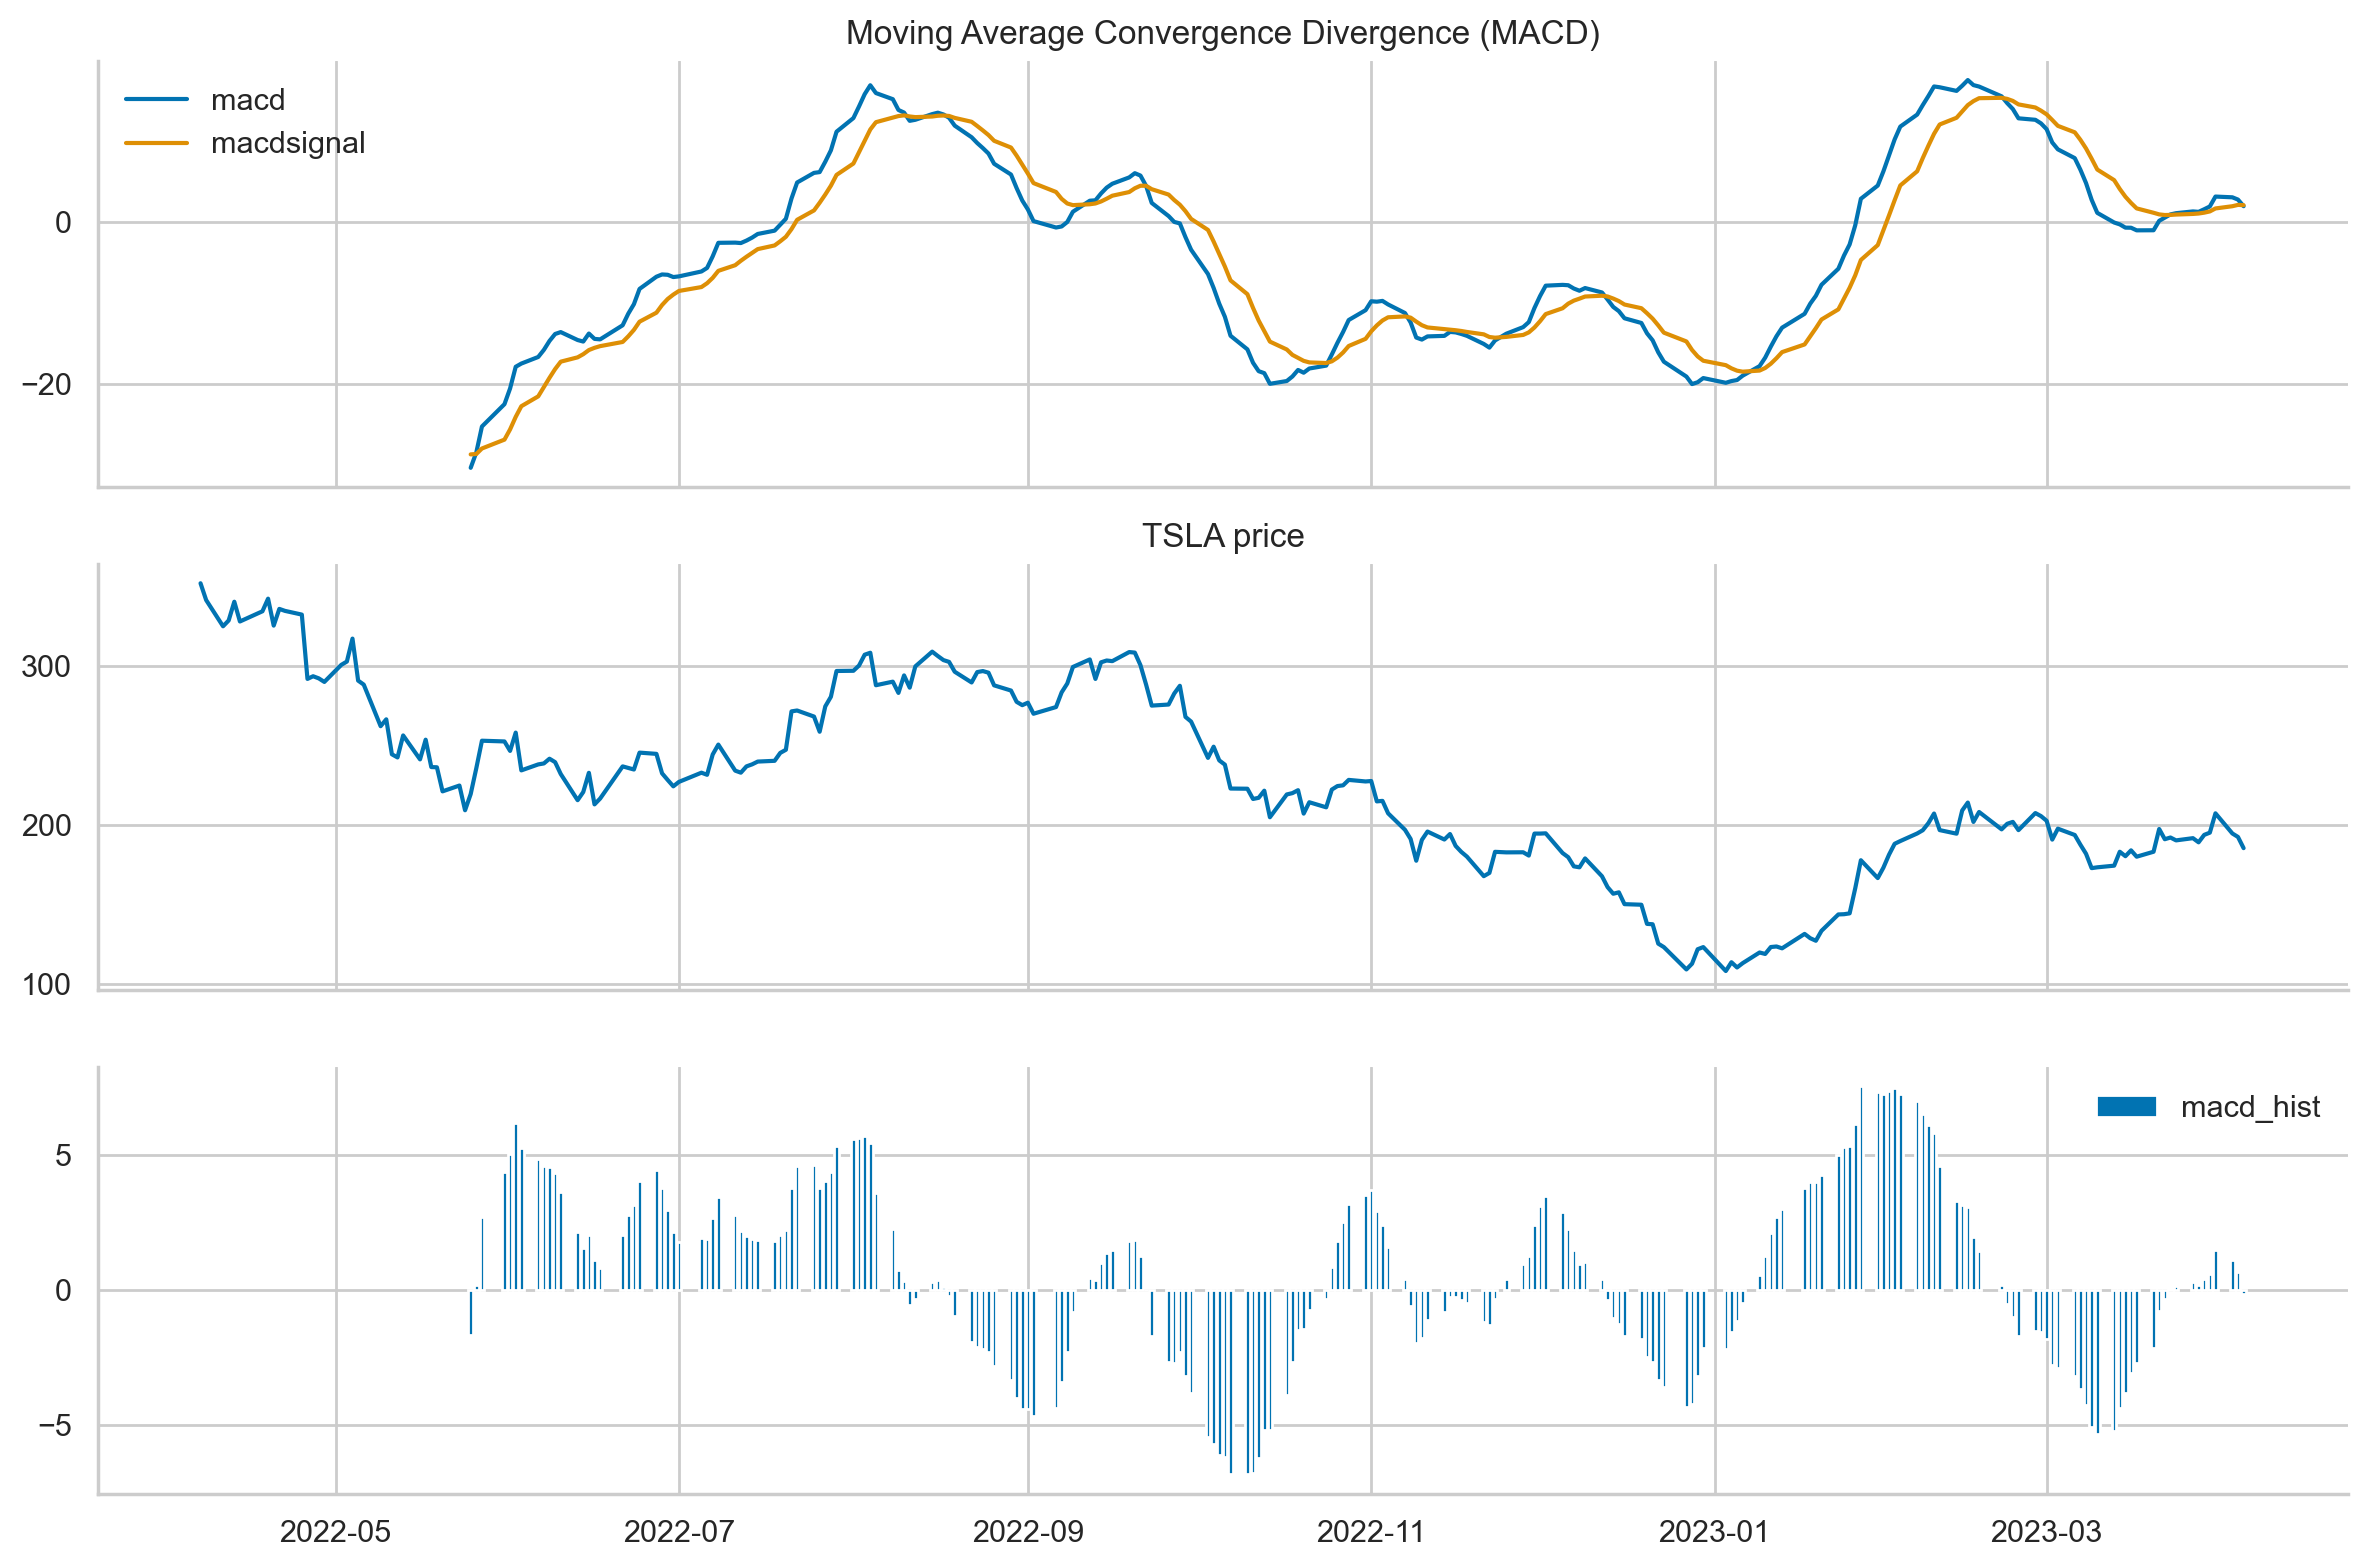

In [72]:
df["macd"], df["macdsignal"], df["macdhist"] = talib.MACD(df["Adj Close"], fastperiod=12, slowperiod=26, signalperiod=9)

with sns.plotting_context("notebook"):
    fig, ax = plt.subplots(3, 1, sharex=True)

    (df[["macd", "macdsignal"]].plot(ax=ax[0], title="Moving Average Convergence Divergence (MACD)"))
    df['Adj Close'].plot(ax=ax[1], title='TSLA price')
    ax[2].bar(df.index, df["macdhist"].values, label="macd_hist")
    ax[2].legend()
    

    sns.despine()
    plt.tight_layout()

- Correlation is present with the stock rising when shorter SMA (blue) is above the longer one and vice versa

**Candlestick chart**
- These charts includes information about a stock's price movements, opening & closing price, and high & low price for a given period. Bullish candlestick patterns include 'hammer' and 'morning star'. Bearish candlestick patterns include 'shooting star', and 'evening star'. 'Engulfing' and 'three line strike' patterns can go in either direction.
- This chart also includes customizable moving averages & volume

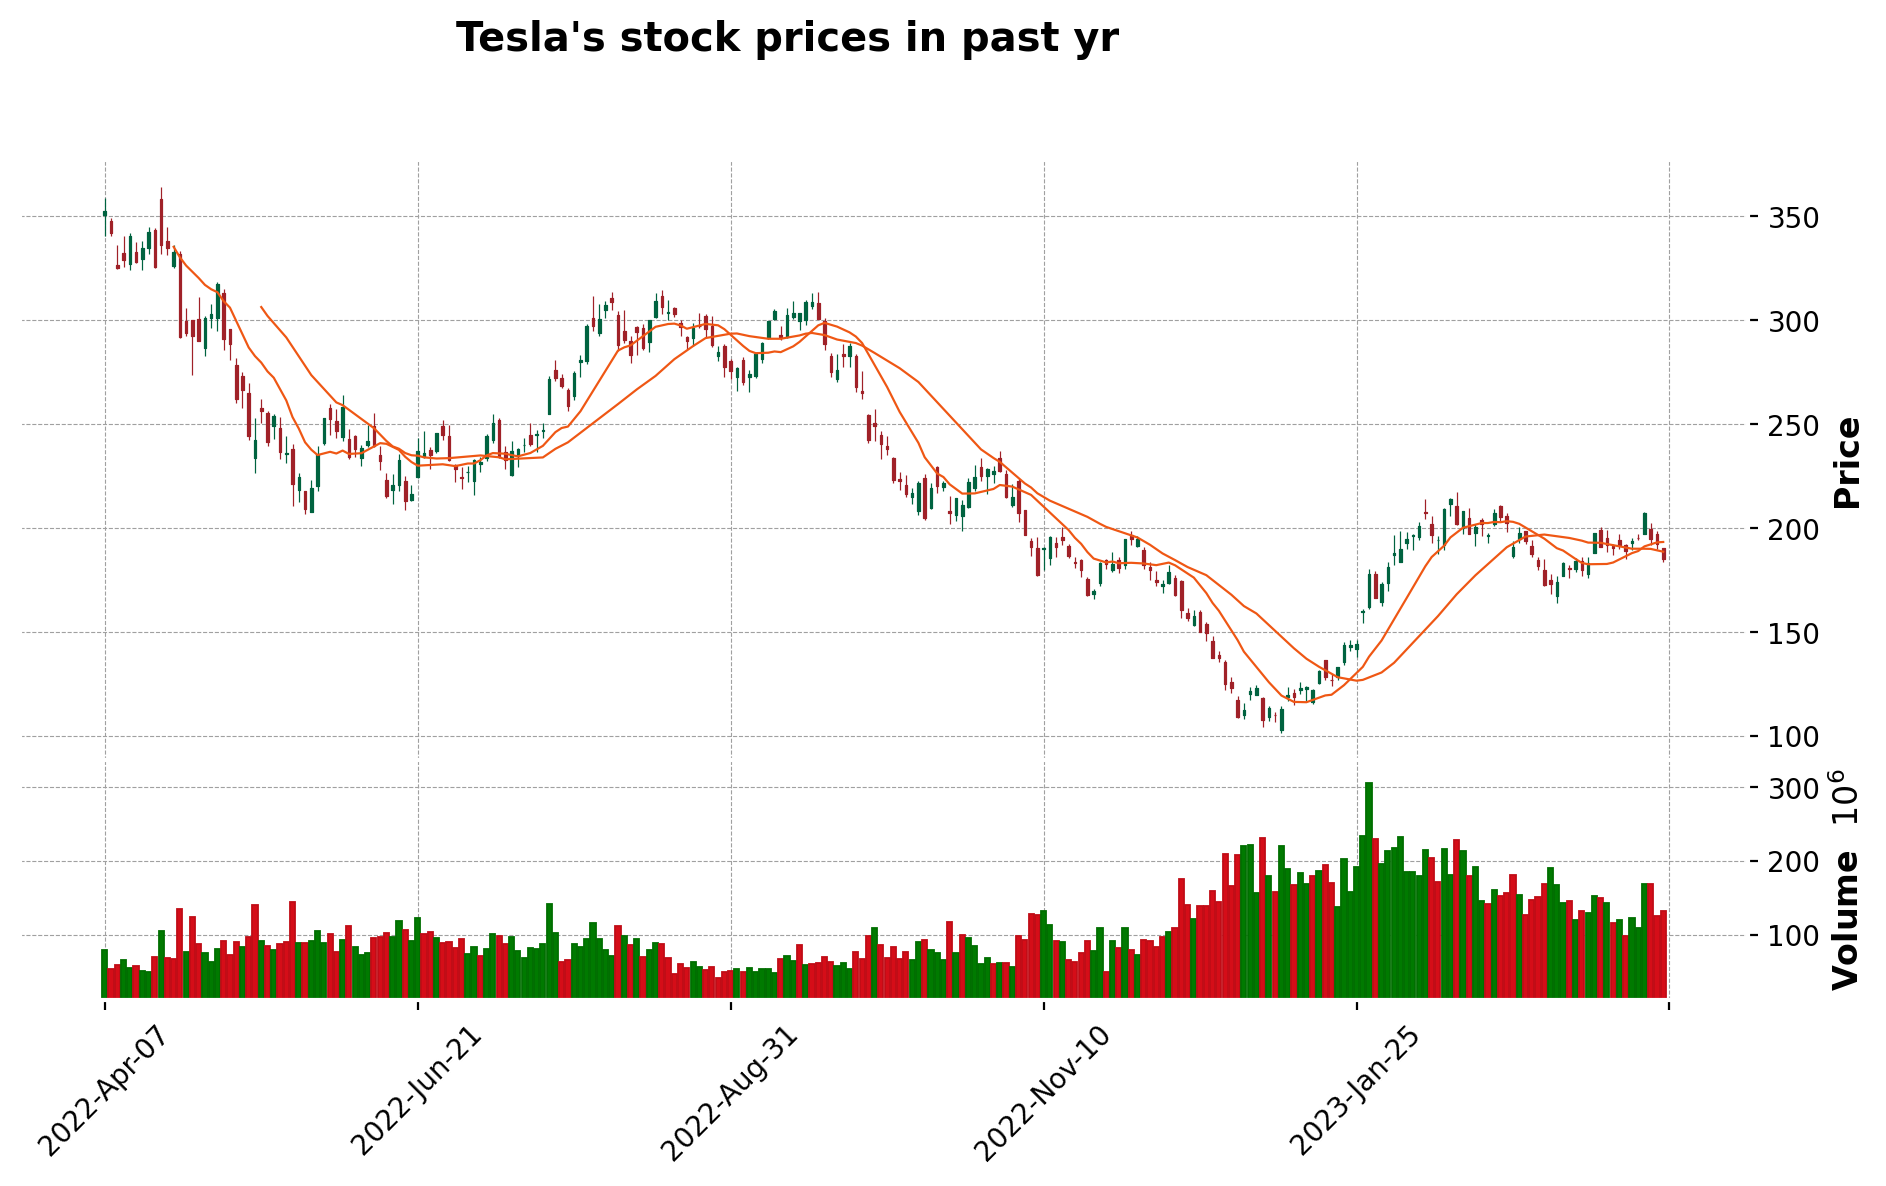

In [73]:
mpf.plot(df, type="candle", mav=(12, 26), volume=True, style="charles", 
         title="Tesla's stock prices in past yr", figsize=(12, 6))

**Detecting trends with candlestick charts**
- For this I'll switch to smaller time increments to try and detect a trend
- The 'three line strike' pattern will be looked for

In [56]:
# bullish trends 

df = min_df.copy()
df["3_line_strike"] = talib.CDL3LINESTRIKE(df["Open"], df["High"], df["Low"], df["Adj Close"])
df[df["3_line_strike"] == 100].tail().round(2)

Open    High     Low   Close  Adj Close  Volume  \
Datetime                                                                       
2023-03-24 05:30:00-04:00  192.28  192.30  191.43  191.47     191.47       0   
2023-03-24 10:34:00-04:00  191.04  191.09  190.16  190.44     190.44  644361   
2023-03-27 11:36:00-04:00  195.25  195.30  194.65  194.82     194.82  438984   
2023-03-30 04:56:00-04:00  194.67  194.68  194.48  194.48     194.48       0   
2023-03-31 10:42:00-04:00  200.49  200.56  200.16  200.17     200.17  597407   

                           % change  % change (ln)   time        date  \
Datetime                                                                
2023-03-24 05:30:00-04:00      -0.0           -0.0  05:30  2023-03-24   
2023-03-24 10:34:00-04:00      -0.0           -0.0  10:34  2023-03-24   
2023-03-27 11:36:00-04:00      -0.0           -0.0  11:36  2023-03-27   
2023-03-30 04:56:00-04:00      -0.0           -0.0  04:56  2023-03-30   
2023-03-31 10:42:00-04:00      -0.0           -0.0  10:42  2023-03-31   

                          intraday after/before  3_line_strike  
Datetime                                                        
2023-03-24 05:30:00-04:00       no  before open            100  
2023-03-24 10:34:00-04:00      yes     intraday            100  
2023-03-27 11:36:00-04:00      yes     intraday            100  
2023-03-30 04:56:00-04:00       no  before open            100  
2023-03-31 10:42:00-04:00      yes     intraday            100

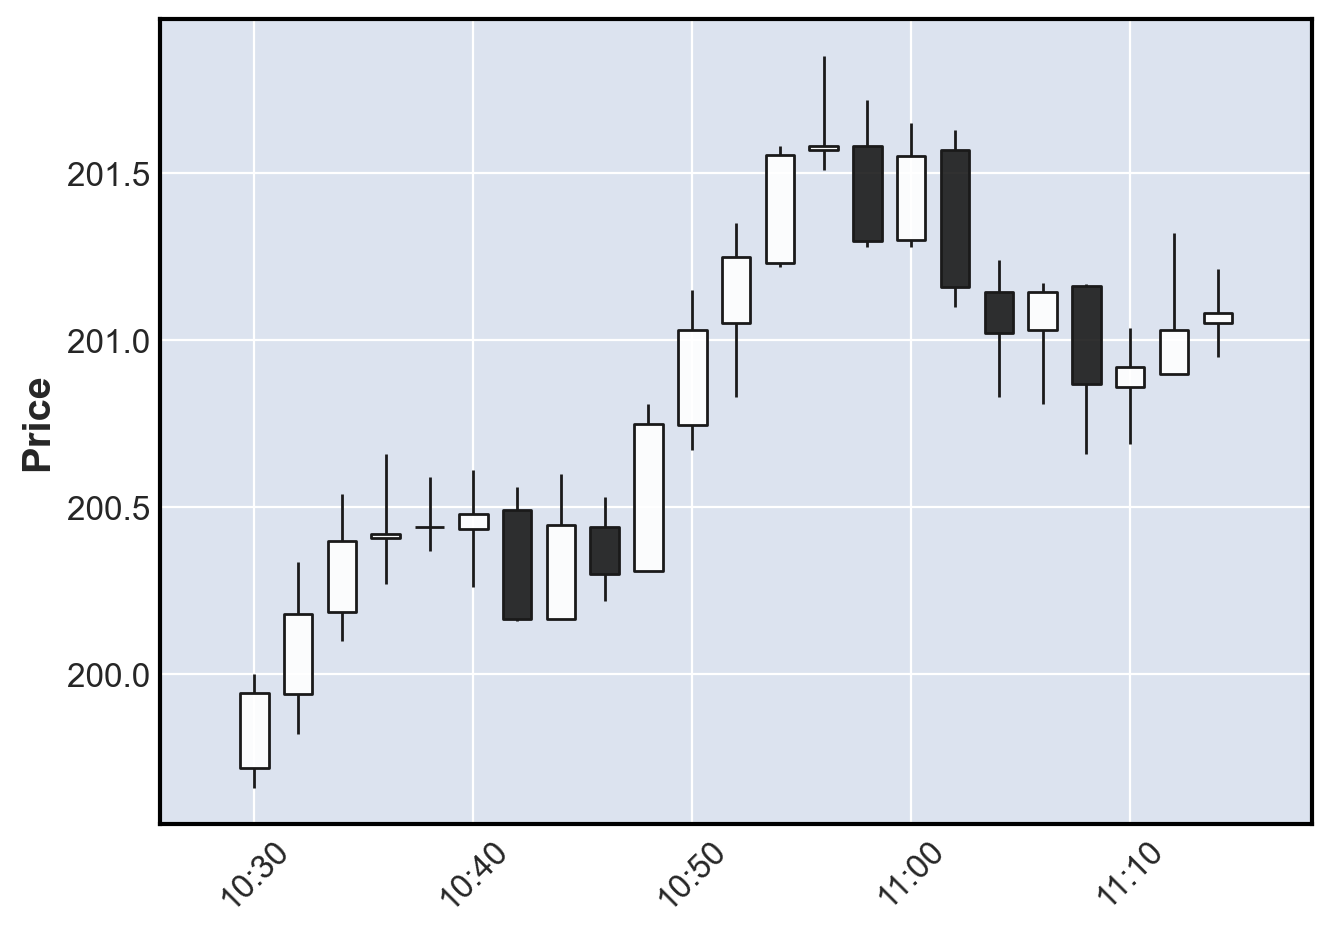

In [57]:
mpf.plot(df["2023-03-31 10:30:00-04:00":"2023-03-31 11:15:00-04:00"], type="candle")

In [58]:
# bearish trend

df = min_df.copy()
df["3_line_strike"] = talib.CDL3LINESTRIKE(df["Open"], df["High"], df["Low"], df["Adj Close"])
df[df["3_line_strike"] == -100].tail().round(2)

Open    High     Low   Close  Adj Close  Volume  \
Datetime                                                                       
2023-03-16 11:42:00-04:00  183.25  183.87  183.25  183.83     183.83  737853   
2023-03-17 17:18:00-04:00  179.94  180.00  179.94  179.99     179.99       0   
2023-03-23 15:42:00-04:00  191.02  191.62  190.83  191.57     191.57  582761   
2023-03-27 11:28:00-04:00  194.59  194.97  194.47  194.84     194.84  459258   
2023-04-05 13:36:00-04:00  185.48  185.80  185.46  185.77     185.77  399740   

                           % change  % change (ln)   time        date  \
Datetime                                                                
2023-03-16 11:42:00-04:00       0.0            0.0  11:42  2023-03-16   
2023-03-17 17:18:00-04:00       0.0            0.0  17:18  2023-03-17   
2023-03-23 15:42:00-04:00       0.0            0.0  15:42  2023-03-23   
2023-03-27 11:28:00-04:00       0.0            0.0  11:28  2023-03-27   
2023-04-05 13:36:00-04:00       0.0            0.0  13:36  2023-04-05   

                          intraday after/before  3_line_strike  
Datetime                                                        
2023-03-16 11:42:00-04:00      yes     intraday           -100  
2023-03-17 17:18:00-04:00       no  after close           -100  
2023-03-23 15:42:00-04:00       no  after close           -100  
2023-03-27 11:28:00-04:00      yes     intraday           -100  
2023-04-05 13:36:00-04:00      yes     intraday           -100

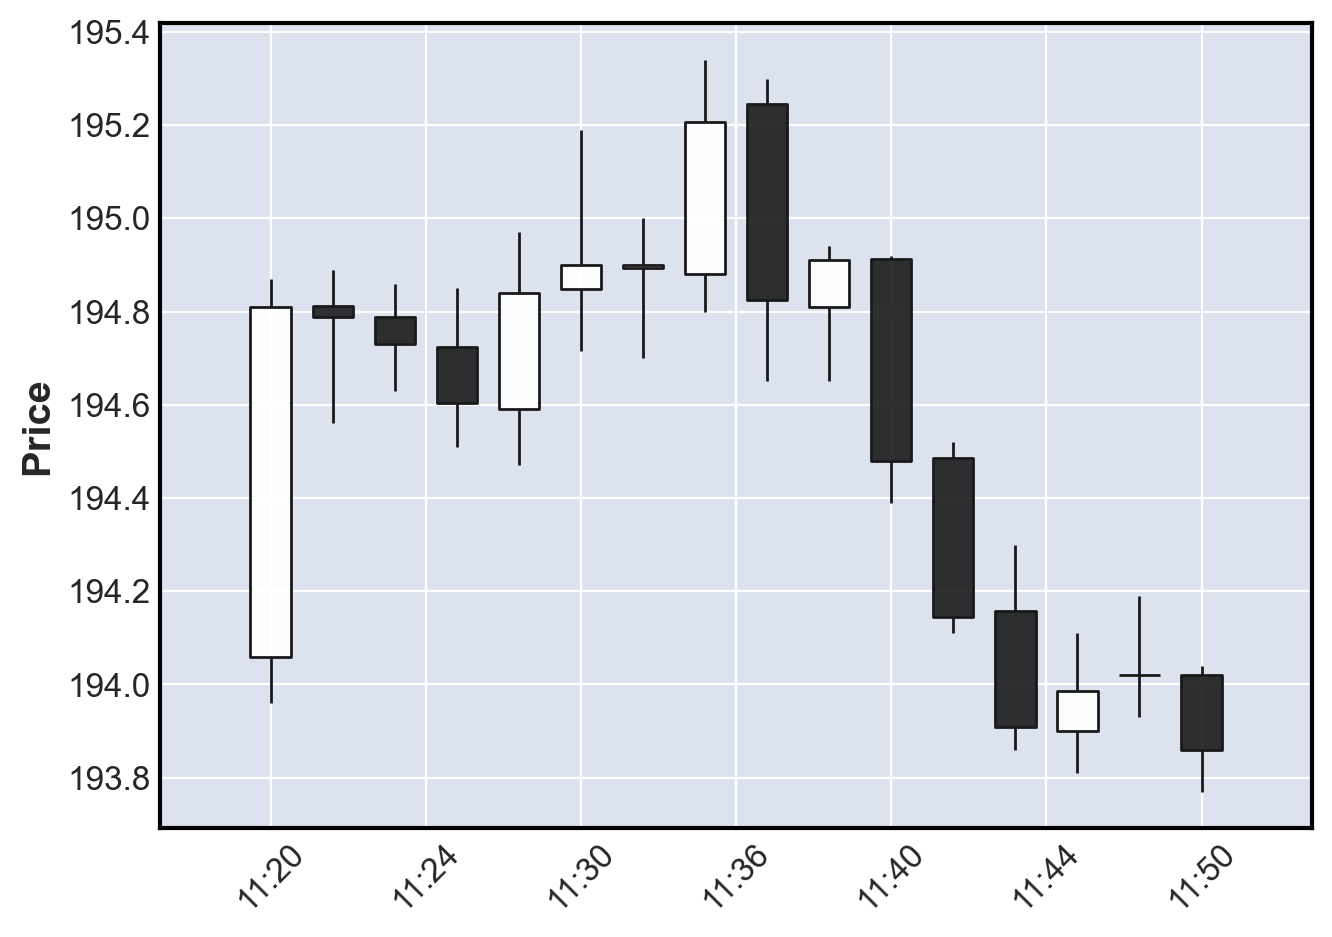

In [59]:
mpf.plot(df["2023-03-27 11:20:00-04:00":"2023-03-27 11:50:00-04:00"], type="candle")

## Week 3 summary
- In analyzing the Tesla stock data, I found the stock price drastically fell in 2022, from $352 to $166 or about 47%. Around the time it reached $150 in late 2022, the volume spiked and has remained above 100M/day. 
- The stock data is not distributed normally so if I opt for a ML approach that requires normal distribution, this must be dealt with. 
- Various datasets from the US treasury & and FINRA were plotted & analyzed, and only the FINRA short interest data showed promise. The volume spike that started in late 2022 correlated with a spike in short volume.
- Calculated indicators including return volatility, relative strength index, bollinger bands, and moving average convergence divergence all proved usefull and will be referred to in future stages. 
- A candlestick chart was created and bullish & bearish patterns were identified with the three line strike method. 
- An interactive dashboard with relative strength index, bollinger bands, and moving average convergence divergence was created.

## Next steps
- Begin ML testing & evaluation